# Progetto Business Intelligence per i Servizi Finanziari (a.a. 2023-2024)
Luca Pinciroli 885969

## 1. Dati utilizzati

Per prima cosa importiamo le librerie che serviranno a compiere tutte le operazioni necessarie.

In [74]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import seaborn as sns
from scipy import stats
import getFamaFrenchFactors as gff
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display_html
import scipy.optimize as sco
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default')

Dopodiché creiamo una semplice funzione che consente di scaricare i dati giornalieri di un'azione da Yahoo Finance e salvarli in formato CSV per averli sempre a disposizione.

In [75]:
def prendi_dati_titolo(ticker, start_date, end_date):
    
    data_dir = "DatiFinanziari" # Nome della cartella per i file CSV
    os.makedirs(data_dir, exist_ok=True)
    
    
    csv_file = os.path.join(data_dir, f"{ticker}.csv") # Nome del file CSV basato sul ticker
    
    # Funzione per caricare i dati dal CSV
    def carica_da_csv():
        try:
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            if(df.index[0] > start_date):
                return None
            else:
                df = df.loc[start_date:end_date]
                return df
        except (FileNotFoundError, pd.errors.EmptyDataError):
            return None
    
    # Funzione per scaricare i dati da Yahoo Finance e salvarli in un CSV
    def scarica_da_yahoo():
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_csv(csv_file)
        return df
    
    data = carica_da_csv()
    
    if data is None or data.empty:
        data = scarica_da_yahoo()
    
    return data

Scarichiamo i dati dei titoli scelti ed inseriamoli in un DataFrame indicizzato per titolo e data.

In [76]:
# periodo di interesse per tutte le analisi
inizio = dt.datetime(2014, 5, 31)
fine = dt.datetime(2024, 5, 31)

settore_1 = 'Tecnologia elettronica'
settore_2 = 'Vendita al dettaglio'
settore_3 = 'Servizi commerciali'

tickers_settore1 = ['AAPL', 'INTC'] # Tecnologia elettronica
tickers_settore2 = ['AMZN', 'WMT'] # Vendita al dettaglio
tickers_settore3 = ['V', 'MA'] # Servizi commerciali

# Apple, Intel, Amazon, Walmart, Visa, Mastercard
tickers = tickers_settore1 + tickers_settore2 + tickers_settore3
data_frames = []

for ticker in tickers:
    df = prendi_dati_titolo(ticker, inizio, fine)
    df['Ticker'] = ticker
    data_frames.append(df)
    
dataframe_completo = pd.concat(data_frames)
dataframe_completo.set_index(['Ticker', dataframe_completo.index], inplace=True)

dataframe_completo

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2014-06-02   22.641430   22.672501   22.232143   22.451786   19.886335   
       2014-06-03   22.445000   22.812143   22.437500   22.769285   20.167551   
       2014-06-04   22.765715   23.138929   22.718214   23.029285   20.397846   
       2014-06-05   23.078571   23.191786   22.950357   23.119642   20.477880   
       2014-06-06   23.210714   23.259287   23.016787   23.056070   20.421576   
...                       ...         ...         ...         ...         ...   
MA     2024-05-23  456.519989  458.049988  450.440002  451.209991  451.209991   
       2024-05-24  452.510010  454.450012  450.320007  451.179993  451.179993   
       2024-05-28  450.000000  450.630005  442.399994  445.079987  445.079987   
       2024-05-29  442.109985  444.559998  441.799988  442.470001  442.470001   
       2024-05-30  442.209991  444.190002  440.670013  442.100006  442.100006   

                      Volume  
Ticker Date                   
AAPL   2014-06-02  369350800  
       2014-06-03  292709200  
       2014-06-04  335482000  
       2014-06-05  303805600  
       2014-06-06  349938400  
...                      ...  
MA     2024-05-23    2084600  
       2024-05-24    2162100  
       2024-05-28    2670800  
       2024-05-29    1876900  
       2024-05-30    2189900  

[15102 rows x 6 columns]

In [77]:
prezzi_chiusura_giornalieri = dataframe_completo.reset_index().pivot_table(index='Date', columns='Ticker', values='Adj Close', sort=False)
prezzi_chiusura_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-02,19.886335,20.856432,15.442000,20.799511,49.775642,72.443558
2014-06-03,20.167551,21.162474,15.359500,20.785965,49.262768,71.785431
2014-06-04,20.397846,21.116562,15.339000,20.899775,49.288414,71.757195
2014-06-05,20.477880,21.162474,16.178499,20.951254,49.472580,72.246124
2014-06-06,20.421576,21.552671,16.483500,20.921452,49.654415,72.838448
...,...,...,...,...,...,...
2024-05-23,186.880005,30.080000,181.050003,64.839996,274.230011,451.209991
2024-05-24,189.979996,30.719999,180.750000,65.379997,274.489990,451.179993
2024-05-28,189.990005,31.059999,182.149994,65.040001,270.980011,445.079987


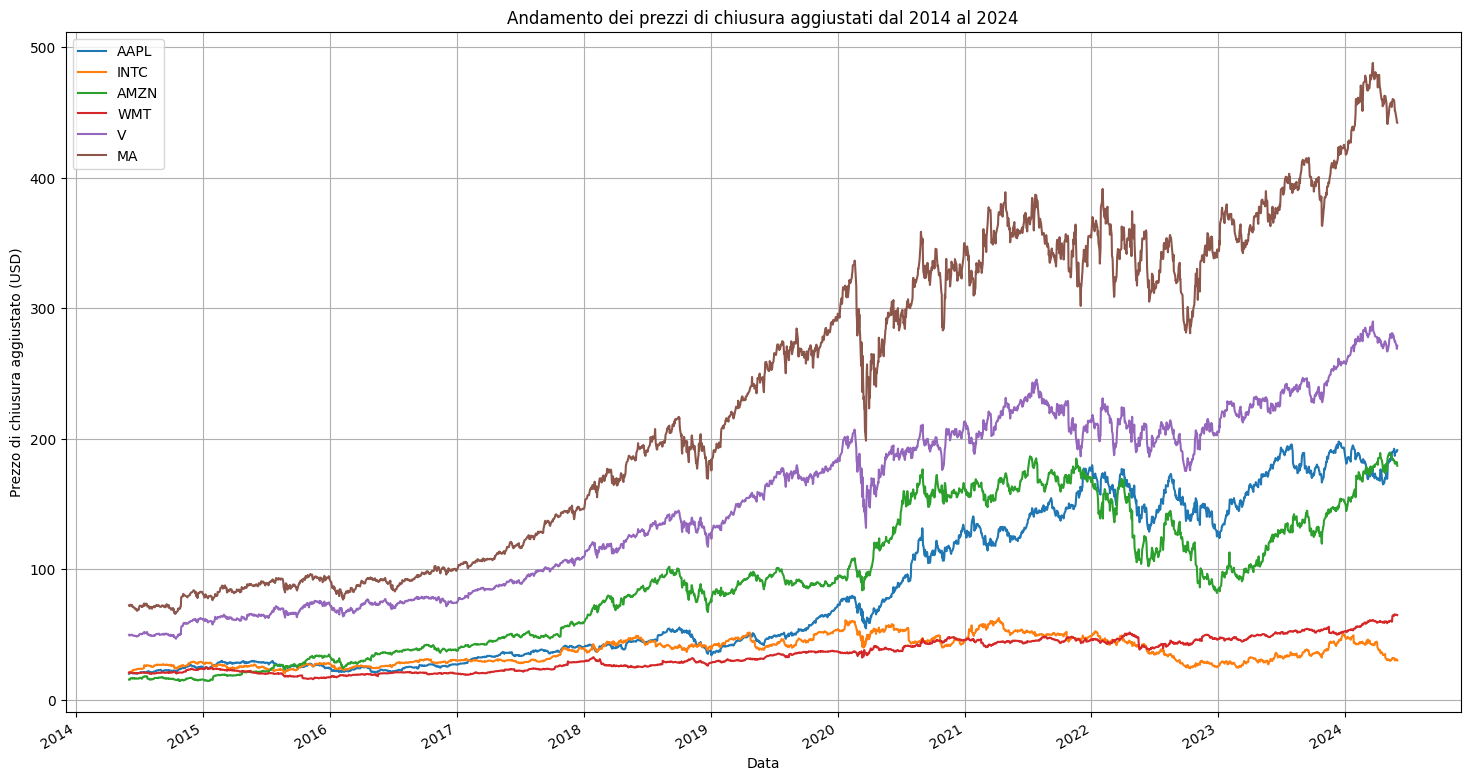

In [78]:
prezzi_chiusura_giornalieri.plot(figsize=(18, 10))
plt.title('Andamento dei prezzi di chiusura aggiustati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura aggiustato (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Statistiche descrittive

Calcoliamo il rendimento cumulato per ciascun titolo.

In primis definiamo una funzione che ci consenta di rappresentare i grafici di ciascun titolo in maniera separata, per evitare di fare confusione.

In [79]:
# Per creare i grafici utilizzo la mappa dei colori predefinita di matplotlib: in questo modo, ogni ticker mantiene il proprio colore nei diversi grafici
mappa_colori = plt.get_cmap('tab10') 

def crea_grafici_separati(dataframe, label):
    # Numero totale di grafici
    n = len(tickers)
    
    # Calcola il numero di righe necessarie
    rows = (n + 1) // 2
    
    # Crea una griglia di sottotrame
    fig, axes = plt.subplots(rows, 2, figsize=(18, 6 * rows))
    
    # Se c'è un numero dispari di grafici, disabilita l'ultima trama vuota
    if n % 2 != 0:
        axes[-1, -1].axis('off')
    
    # Itera attraverso i tickers e genera un grafico separato per ciascuno di essi
    for i, ticker in enumerate(tickers):
        ax = axes[i // 2, i % 2]
        
        # Seleziona solo i dati relativi al ticker corrente
        data = dataframe[ticker]

        # Crea il grafico
        ax.plot(data.index, data, label=ticker, color=mappa_colori(i))  
        ax.set_title(f'{ticker}')  
        ax.set_xlabel('Data')  
        ax.set_ylabel(label) 
        ax.legend() 
        ax.grid(True)

    plt.tight_layout()
    plt.show()

A partire dal DataFrame contenente i prezzi di chiusura giornalieri andiamo a ricavare i rendimenti netti e lordi.

In [80]:
# calcolo i rendimenti netti (come variazione di prezzo giornaliera) e rimuovo i NaN
rendimenti_netti_giornalieri = prezzi_chiusura_giornalieri.pct_change().dropna()
rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014141,0.014674,-0.005343,-0.000651,-0.010304,-0.009085
2014-06-04,0.011419,-0.002169,-0.001335,0.005475,0.000521,-0.000393
2014-06-05,0.003924,0.002174,0.054730,0.002463,0.003736,0.006814
2014-06-06,-0.002750,0.018438,0.018852,-0.001422,0.003675,0.008199
2014-06-09,0.016001,-0.009230,-0.006582,-0.002591,-0.001972,-0.007874
...,...,...,...,...,...,...
2024-05-23,-0.021058,-0.042648,-0.011358,-0.006284,-0.004899,-0.011631
2024-05-24,0.016588,0.021277,-0.001657,0.008328,0.000948,-0.000066
2024-05-28,0.000053,0.011068,0.007745,-0.005200,-0.012787,-0.013520


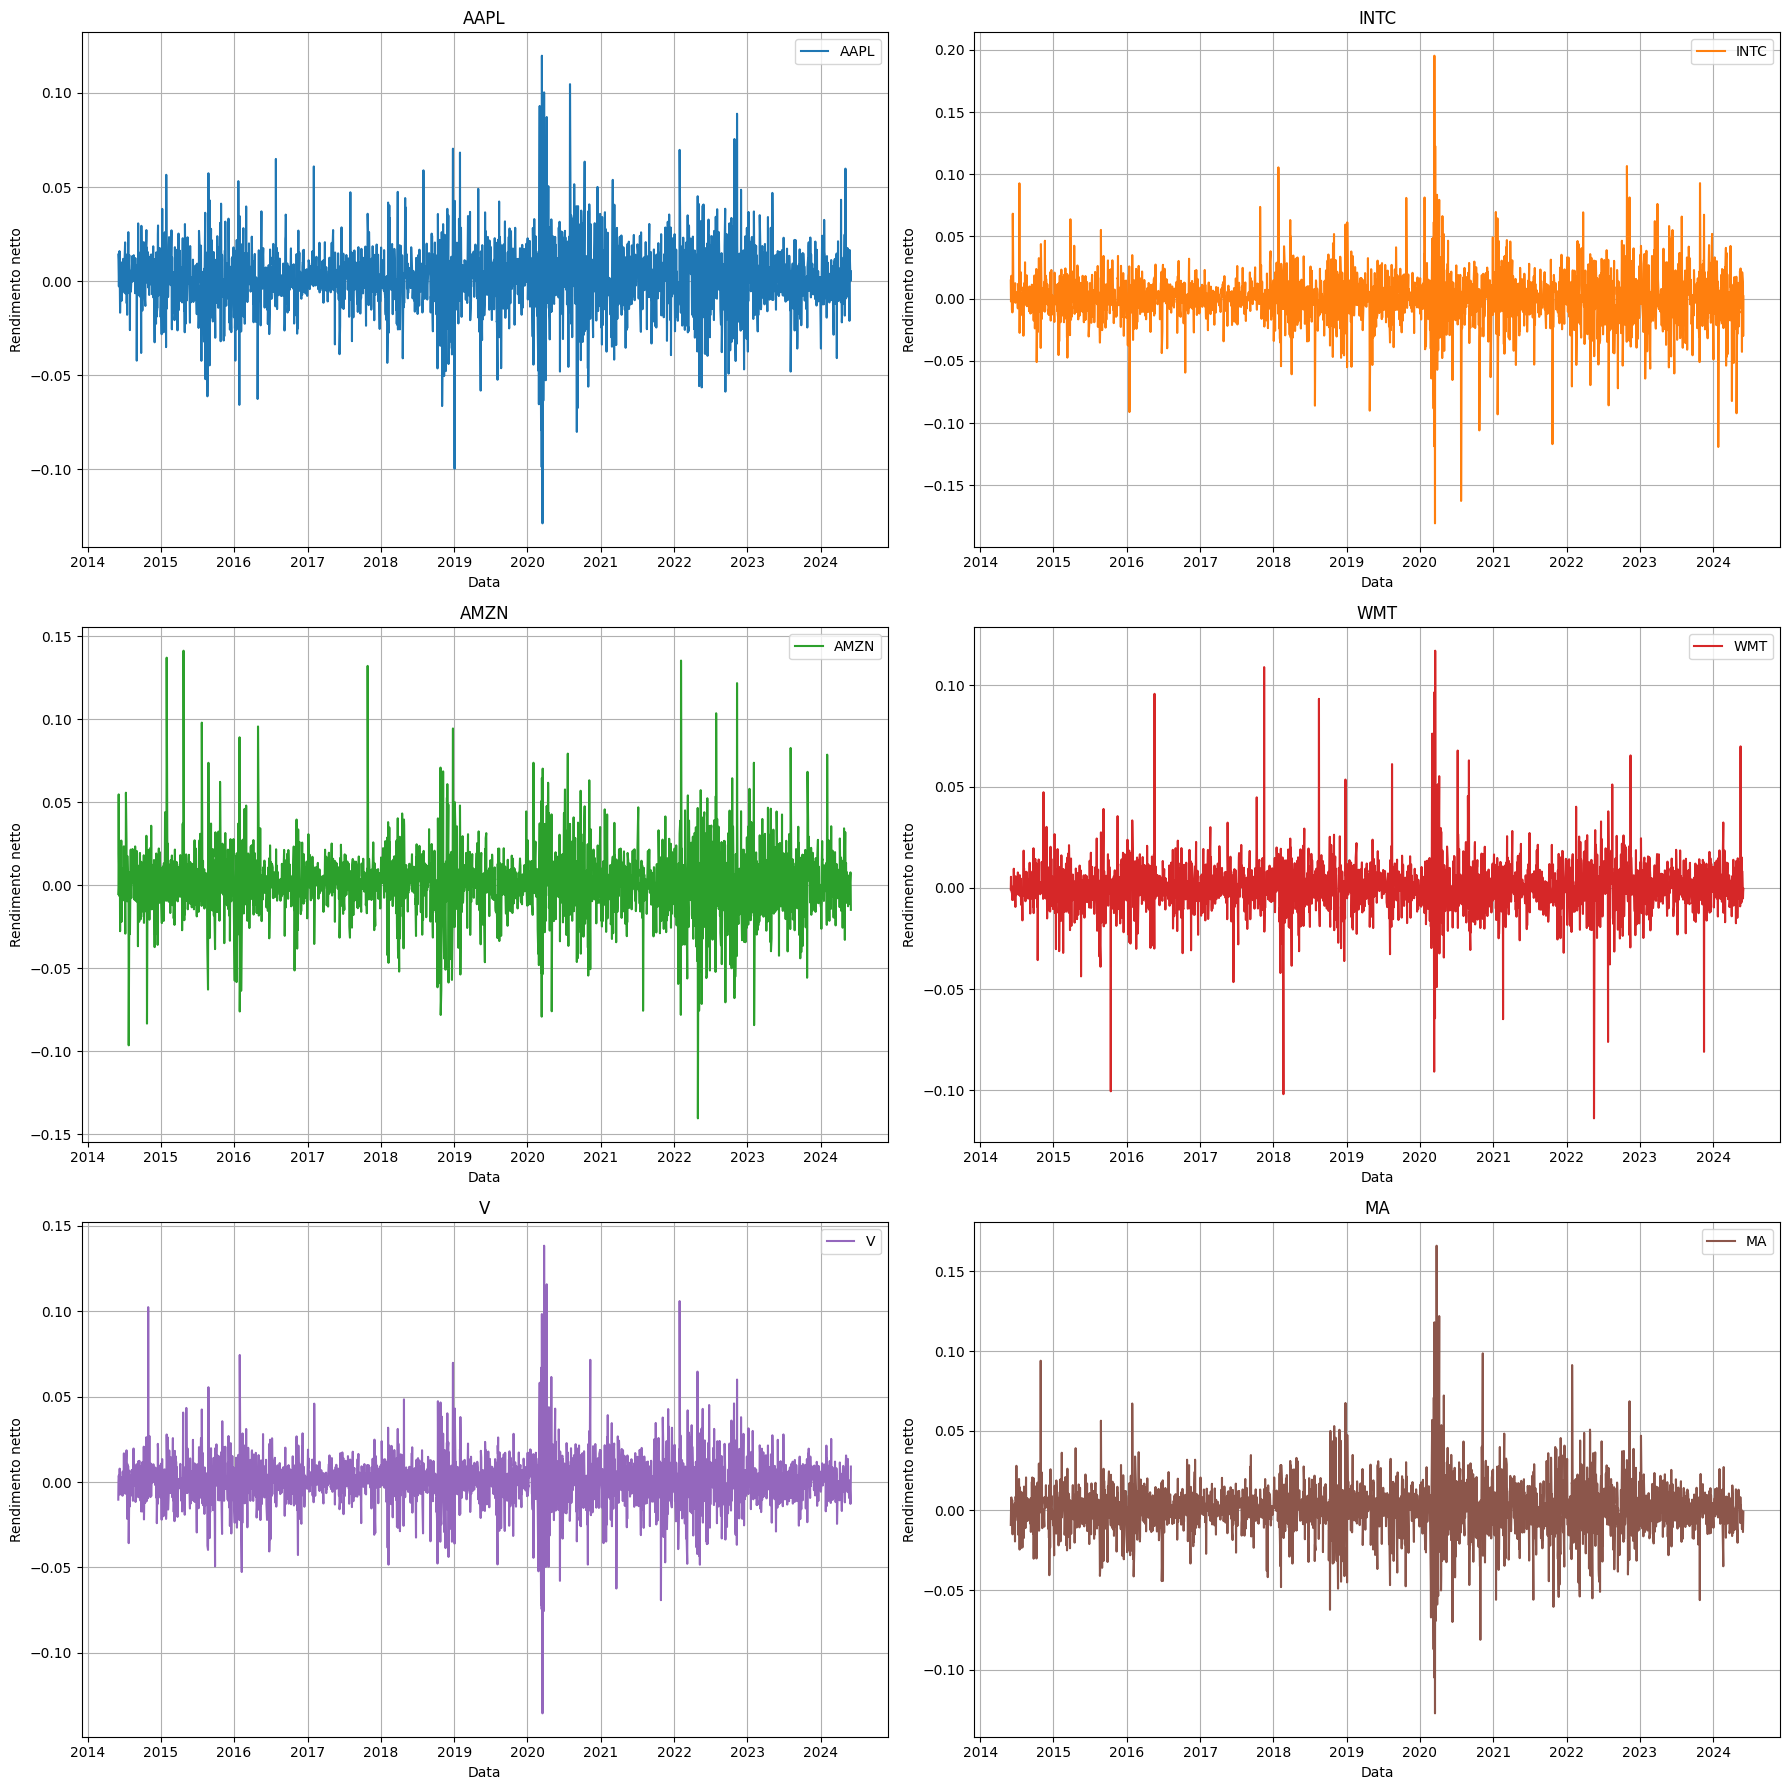

In [81]:
crea_grafici_separati(rendimenti_netti_giornalieri, 'Rendimento netto')

In [82]:
# ricavo i rendimenti lordi a partire da quelli netti
rendimenti_lordi_giornalieri = rendimenti_netti_giornalieri + 1
rendimenti_lordi_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014141,1.014674,0.994657,0.999349,0.989696,0.990915
2014-06-04,1.011419,0.997831,0.998665,1.005475,1.000521,0.999607
2014-06-05,1.003924,1.002174,1.054730,1.002463,1.003736,1.006814
2014-06-06,0.997250,1.018438,1.018852,0.998578,1.003675,1.008199
2014-06-09,1.016001,0.990770,0.993418,0.997409,0.998028,0.992126
...,...,...,...,...,...,...
2024-05-23,0.978942,0.957352,0.988642,0.993716,0.995101,0.988369
2024-05-24,1.016588,1.021277,0.998343,1.008328,1.000948,0.999934
2024-05-28,1.000053,1.011068,1.007745,0.994800,0.987213,0.986480


In [83]:
# calcolo i rendimenti cumulati come prodotto cumulativo dei rendimenti lordi
rendimenti_cumulati = rendimenti_lordi_giornalieri.cumprod()

rendimenti_cumulati

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014141,1.014674,0.994657,0.999349,0.989696,0.990915
2014-06-04,1.025722,1.012472,0.993330,1.004820,0.990212,0.990526
2014-06-05,1.029746,1.014674,1.047695,1.007296,0.993911,0.997275
2014-06-06,1.026915,1.033382,1.067446,1.005863,0.997565,1.005451
2014-06-09,1.043347,1.023845,1.060420,1.003257,0.995597,0.997534
...,...,...,...,...,...,...
2024-05-23,9.397408,1.442241,11.724517,3.117381,5.509321,6.228435
2024-05-24,9.553293,1.472927,11.705090,3.143343,5.514544,6.228021
2024-05-28,9.553797,1.489229,11.795751,3.126997,5.444028,6.143817


Visualizziamo l'andamento dei rendimenti cumulati nel corso del tempo.

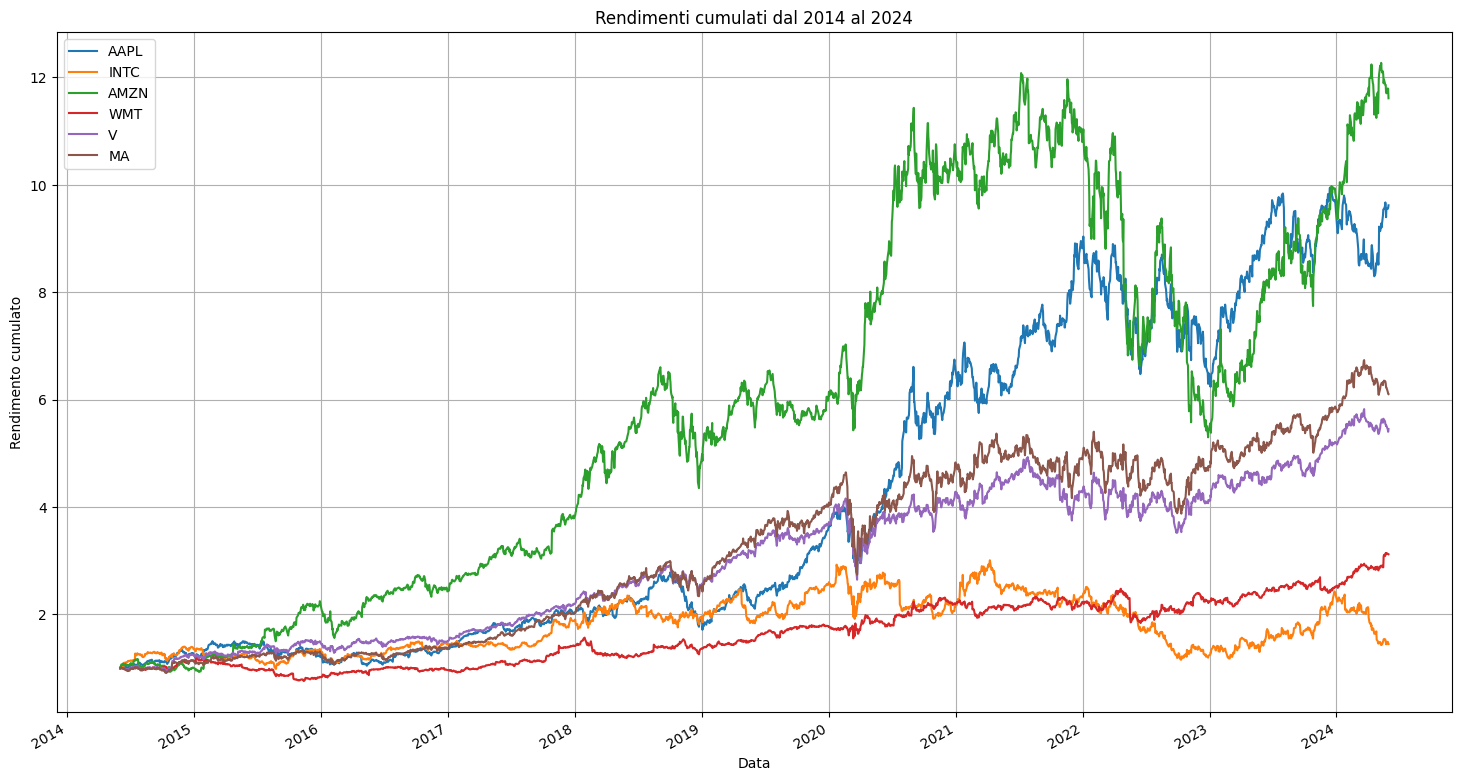

In [84]:
rendimenti_cumulati.plot(figsize=(18, 10))
plt.title('Rendimenti cumulati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Rendimento cumulato')
plt.legend()
plt.grid(True)
plt.show()

Analogamente, visualizziamo l'evoluzione della volatilità nel tempo.

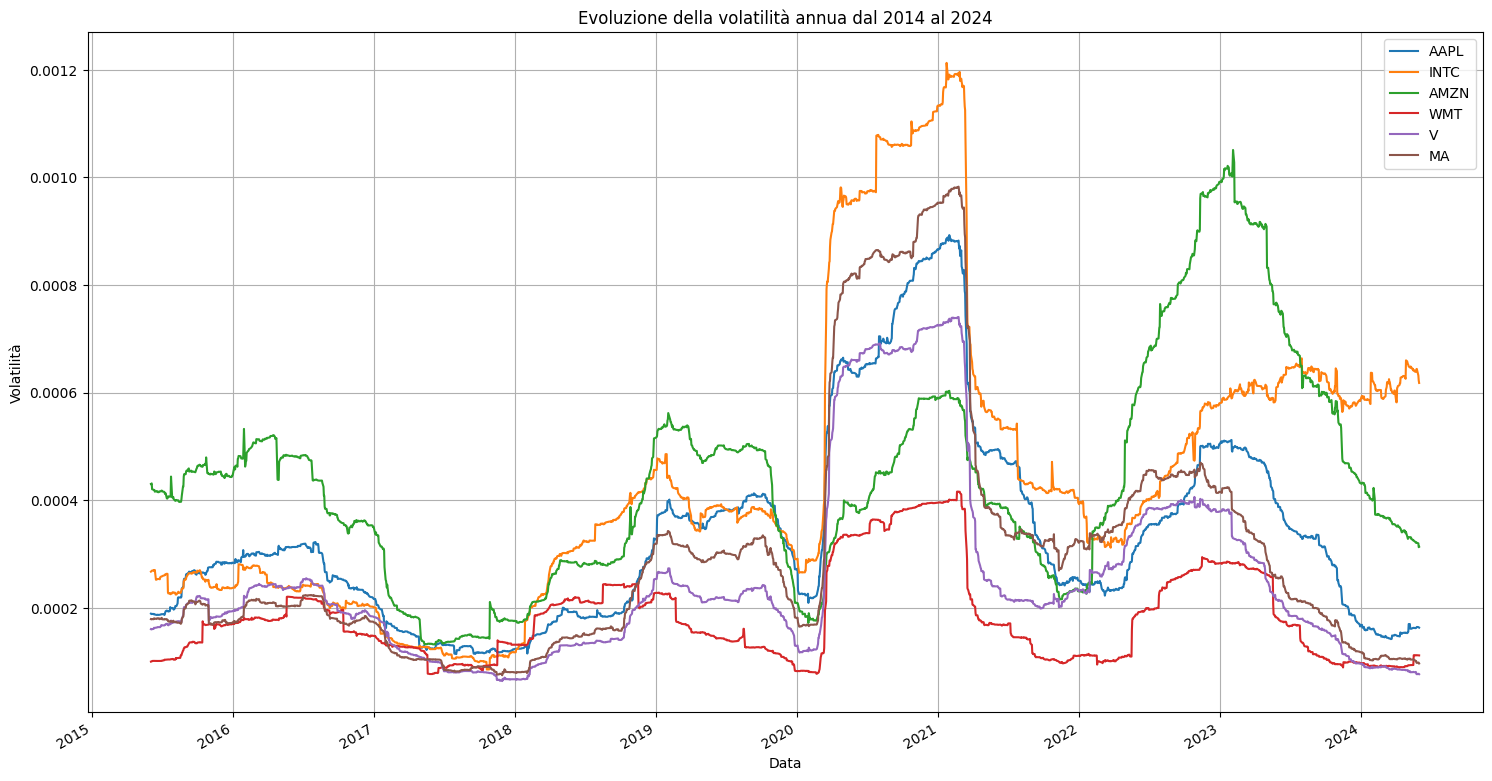

In [85]:
rendimenti_netti_giornalieri.rolling(window=252).var().plot(figsize=(18, 10))
plt.title('Evoluzione della volatilità annua dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Volatilità')
plt.legend()
plt.grid(True)
plt.show()

Ora calcoliamo il rendimento composto annuo sul periodo considerato (Compound Annual Growth Rate, CAGR).

In [86]:
numero_anni = (fine - inizio) / dt.timedelta(days=365)
CAGR = rendimenti_cumulati.iloc[-1] ** (1 / numero_anni) - 1 # sfrutto i rendimenti cumulati che ho già calcolato
CAGR.rename("CAGR", inplace=True)

CAGR

Ticker
AAPL    0.253814
INTC    0.037646
AMZN    0.277630
WMT     0.120397
V       0.184630
MA      0.198085
Name: CAGR, dtype: float64

A partire dai rendimenti lordi giornalieri ricaviamo i rendimenti logaritmici.

In [87]:
rendimenti_logaritmici = np.log(rendimenti_lordi_giornalieri) # i rendimenti lordi li ho calcolati in precedenza
rendimenti_logaritmici

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014042,0.014567,-0.005357,-0.000651,-0.010357,-0.009126
2014-06-04,0.011354,-0.002172,-0.001336,0.005460,0.000520,-0.000393
2014-06-05,0.003916,0.002172,0.053285,0.002460,0.003730,0.006791
2014-06-06,-0.002753,0.018270,0.018677,-0.001423,0.003669,0.008165
2014-06-09,0.015874,-0.009273,-0.006604,-0.002594,-0.001974,-0.007905
...,...,...,...,...,...,...
2024-05-23,-0.021283,-0.043584,-0.011423,-0.006303,-0.004911,-0.011700
2024-05-24,0.016452,0.021053,-0.001658,0.008294,0.000948,-0.000066
2024-05-28,0.000053,0.011007,0.007716,-0.005214,-0.012870,-0.013612


Vediamo il livello di correlazione che sussiste tra i rendimenti dei titoli appartenenti allo stesso settore.

In [88]:
rendimenti_netti_giornalieri[tickers_settore1].corr()

Ticker,AAPL,INTC
Ticker,,
AAPL,1.000000,0.512803
INTC,0.512803,1.000000


In [89]:
rendimenti_netti_giornalieri[tickers_settore2].corr()

Ticker,AMZN,WMT
Ticker,,
AMZN,1.000000,0.250431
WMT,0.250431,1.000000


In [90]:
rendimenti_netti_giornalieri[tickers_settore3].corr()

Ticker,V,MA
Ticker,,
V,1.000000,0.895385
MA,0.895385,1.000000


Visualizziamo come i rendimenti sono distribuiti attraverso degli istogrammi. 

Per ciascun titolo visualizziamo i grafici diagnostici a tre sezioni.

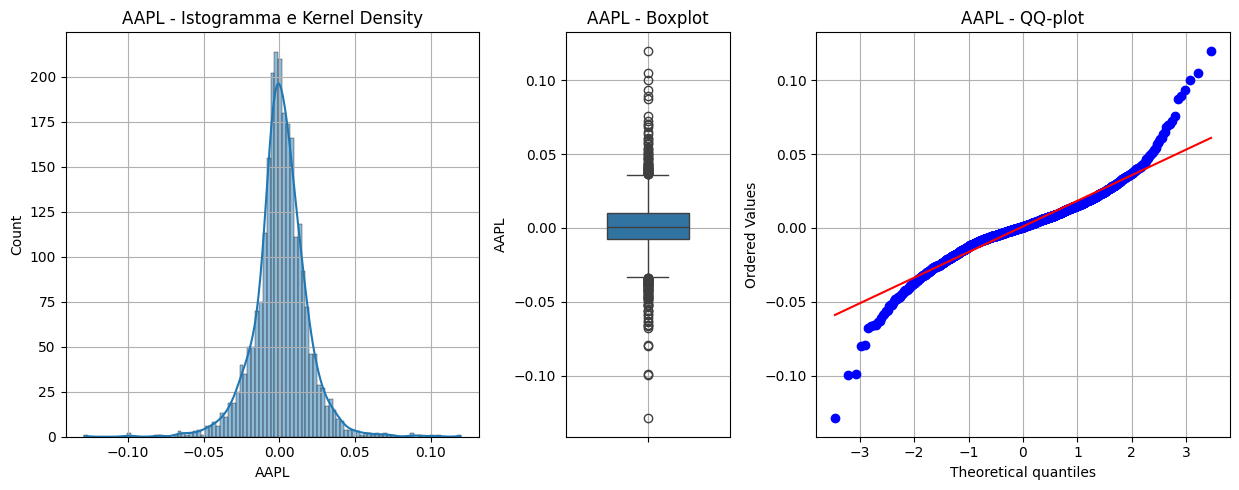

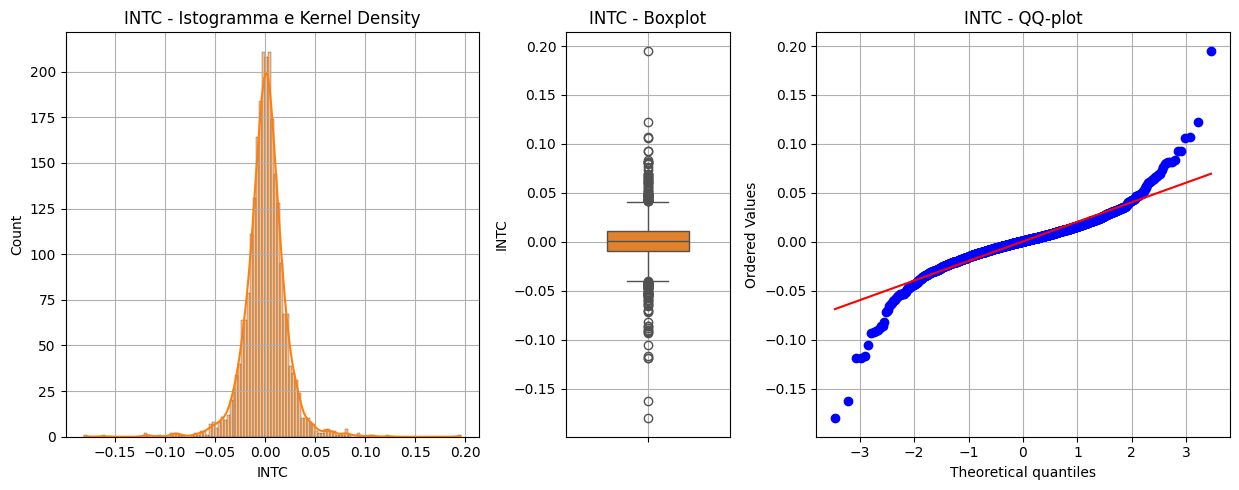

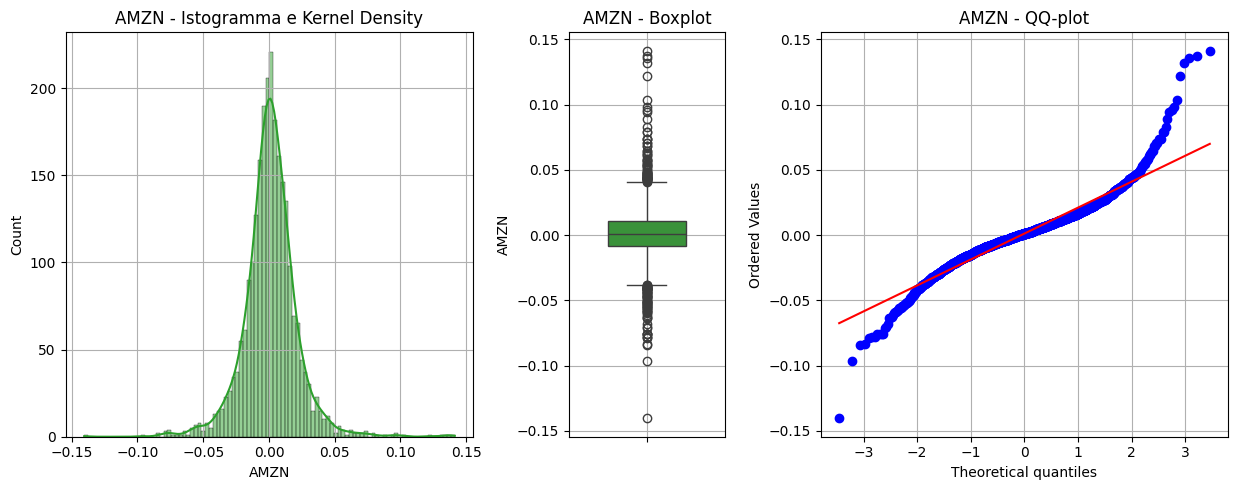

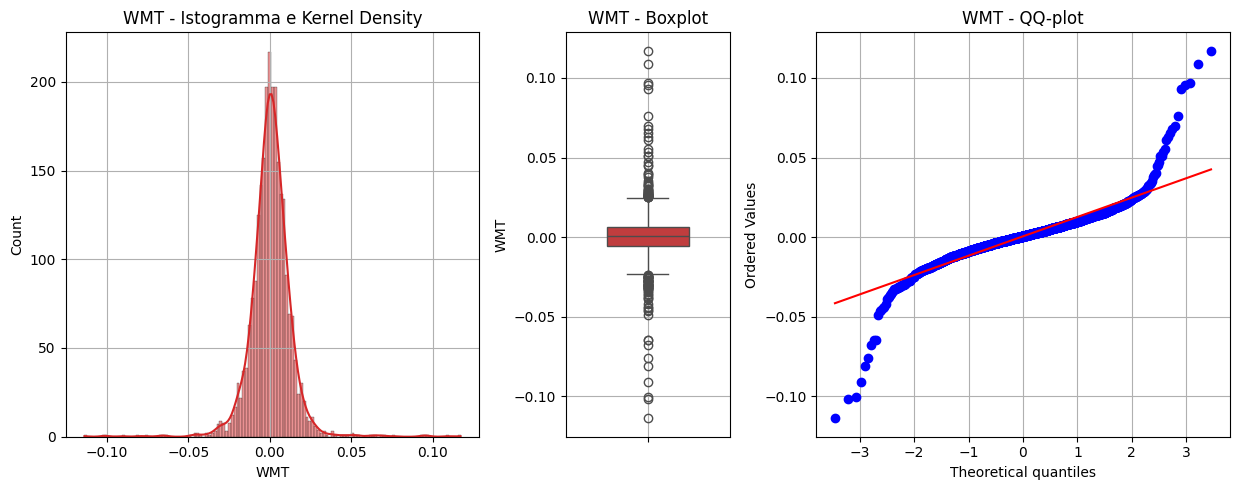

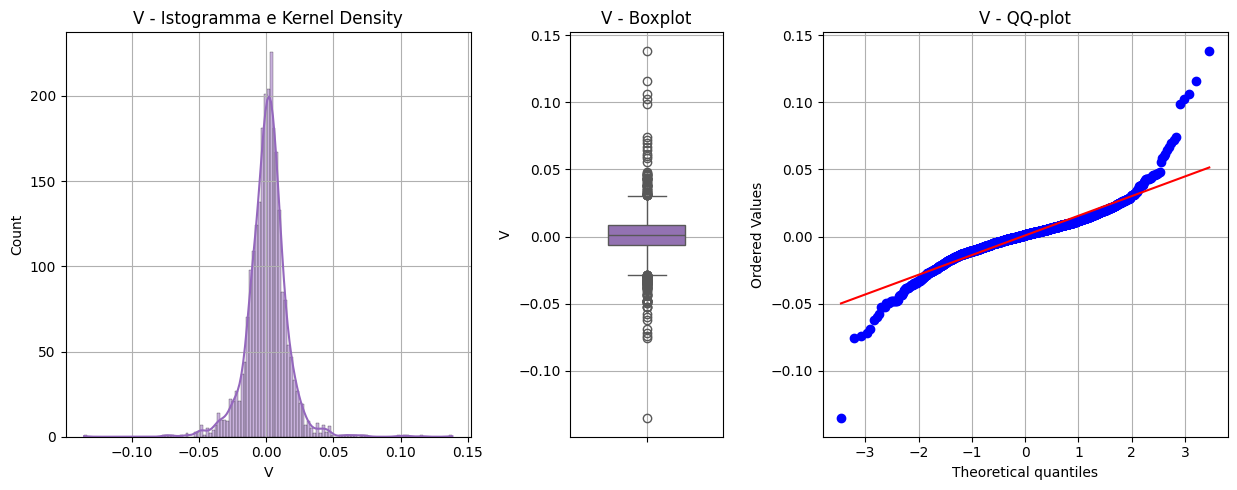

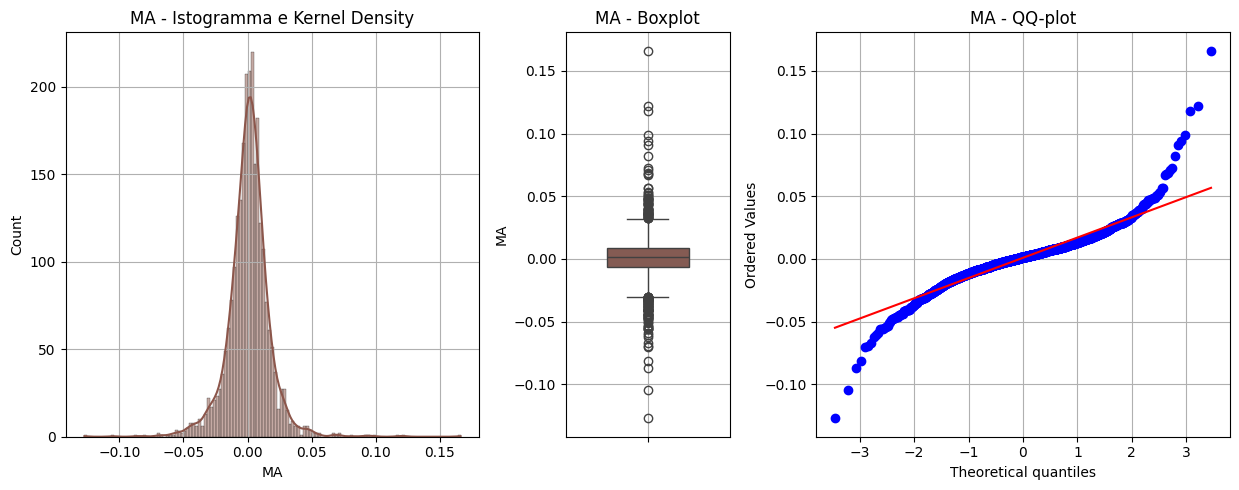

In [91]:
def crea_grafici_diagnostici(dataframe, ticker, colore):
    plt.figure(figsize=(15, 5))

    # Istogramma e kernel density
    plt.subplot2grid((1, 6), (0, 0), colspan=2, rowspan=1)
    sns.histplot(data=dataframe[ticker], kde=True, color=colore)
    plt.title(f'{ticker} - Istogramma e Kernel Density')
    plt.grid(True)

    # Boxplot
    plt.subplot2grid((1, 6), (0, 2), colspan=1, rowspan=1)
    sns.boxplot(data=dataframe[ticker], color=colore, width=0.5)
    plt.title(f'{ticker} - Boxplot')
    plt.grid(True)

    # QQ-plot
    plt.subplot2grid((1, 6), (0, 3), colspan=2, rowspan=1)
    stats.probplot(dataframe[ticker], dist="norm", plot=plt)
    plt.title(f'{ticker} - QQ-plot')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Esegui la funzione per ciascun titolo
for i, ticker in enumerate(tickers):
    colore = mappa_colori(i % 10)  # L'operazione modulo assicura che non superiamo l'indice massimo della mappa
    crea_grafici_diagnostici(rendimenti_netti_giornalieri, ticker, colore)

Calcoliamo le statistiche descrittive univariate dei rendimenti netti giornalieri.

In [92]:
statistiche_rendimenti_netti_giornalieri = rendimenti_netti_giornalieri.describe()

varianza = pd.Series(rendimenti_netti_giornalieri.var()).to_frame().T
kurtosi = pd.Series(rendimenti_netti_giornalieri.kurtosis()).to_frame().T
skewness = pd.Series(rendimenti_netti_giornalieri.skew()).to_frame().T
varianza.rename(index={0: 'var'}, inplace=True)
kurtosi.rename(index={0: 'kurt'}, inplace=True)
skewness.rename(index={0: 'skew'}, inplace=True)

statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, varianza])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, kurtosi])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, skewness])

statistiche_rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,0.001059,0.000370,0.001187,0.000539,0.000793,0.000863
std,0.017841,0.021046,0.020638,0.013181,0.015427,0.016970
min,-0.128647,-0.180415,-0.140494,-0.113757,-0.135472,-0.127255
25%,-0.007324,-0.009571,-0.008609,-0.005382,-0.006481,-0.006842
50%,0.000821,0.000795,0.001153,0.000576,0.001316,0.001395
75%,0.010141,0.010663,0.011145,0.006606,0.008235,0.008719
max,0.119808,0.195213,0.141311,0.117085,0.138426,0.166109
var,0.000318,0.000443,0.000426,0.000174,0.000238,0.000288
kurt,5.360348,10.311202,6.337522,16.261183,10.399218,10.021949


Ora vediamo la matrice di covarianza e la matrice di correlazione.

In [93]:
rendimenti_netti_giornalieri.cov() # matrice di covarianza

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,0.000318,0.000193,0.000203,0.000075,0.000158,0.000178
INTC,0.000193,0.000443,0.000173,0.000076,0.000150,0.000169
AMZN,0.000203,0.000173,0.000426,0.000068,0.000149,0.000169
WMT,0.000075,0.000076,0.000068,0.000174,0.000059,0.000064
V,0.000158,0.000150,0.000149,0.000059,0.000238,0.000234
MA,0.000178,0.000169,0.000169,0.000064,0.000234,0.000288


In [94]:
rendimenti_netti_giornalieri.corr() # matrice di correlazione

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,1.000000,0.512803,0.551242,0.320540,0.572258,0.586861
INTC,0.512803,1.000000,0.397254,0.274462,0.461147,0.474221
AMZN,0.551242,0.397254,1.000000,0.250431,0.466580,0.483197
WMT,0.320540,0.274462,0.250431,1.000000,0.289393,0.284192
V,0.572258,0.461147,0.466580,0.289393,1.000000,0.895385
MA,0.586861,0.474221,0.483197,0.284192,0.895385,1.000000


Vediamo com'è stato l'andamento nel tempo della correlazione tra titoli dello stesso settore.

In [95]:
def andamento_correlazione_rendimenti(tickers_settore, nome_settore, colore):
    # Calcola la correlazione tra i titoli del settore
    correlazione = rendimenti_netti_giornalieri[tickers_settore[0]].rolling(window=252).corr(rendimenti_netti_giornalieri[tickers_settore[1]])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    correlazione.plot(label=nome_settore, ax=ax, color=colore)

    ax.axhline(rendimenti_netti_giornalieri.corr().loc[tickers_settore[0], tickers_settore[1]], c='r')
    plt.legend()
    plt.title(f'Andamento della correlazione nel tempo dei titoli per il settore {nome_settore}')
    plt.xlabel('Data')
    plt.ylabel('Correlazione')
    plt.grid(True)
    plt.show()

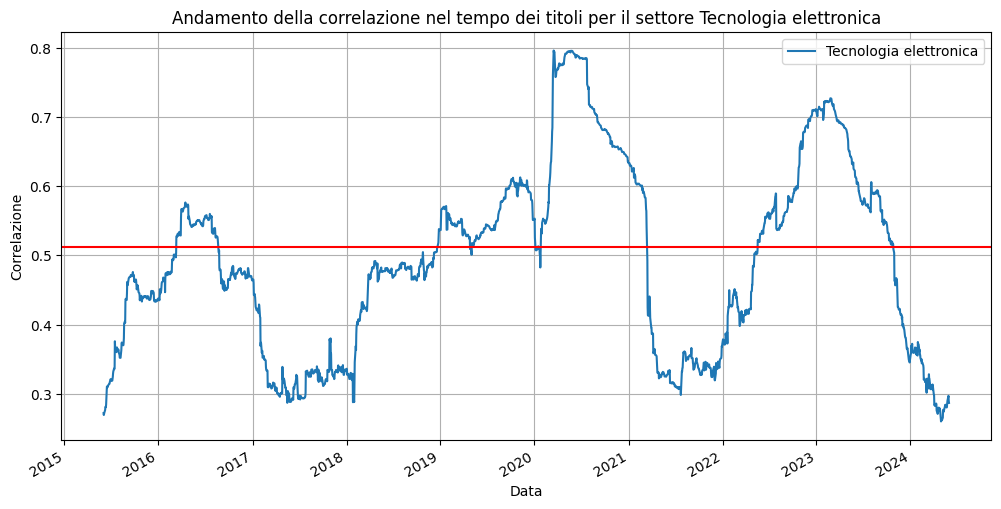

In [96]:
andamento_correlazione_rendimenti(tickers_settore1, settore_1, mappa_colori(0))

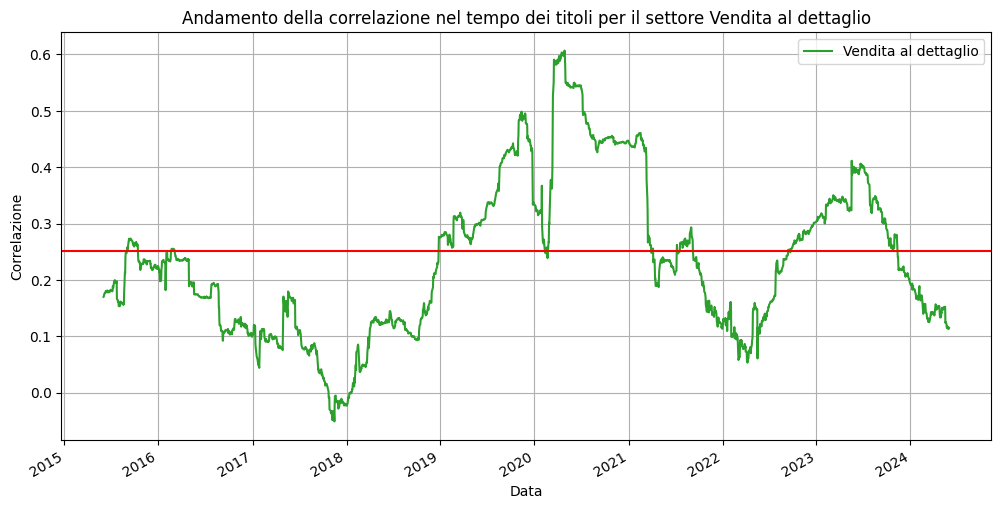

In [97]:
andamento_correlazione_rendimenti(tickers_settore2, settore_2, mappa_colori(2))

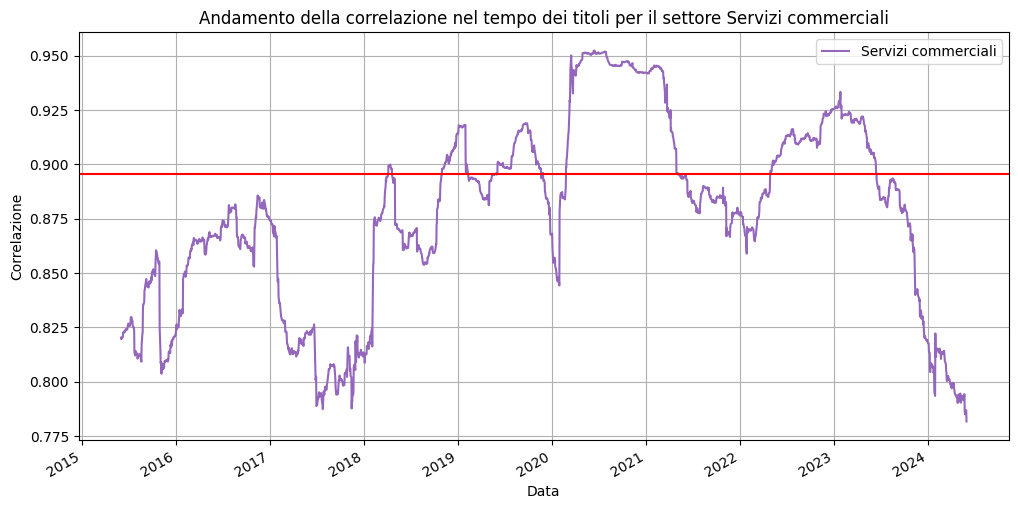

In [98]:
andamento_correlazione_rendimenti(tickers_settore3, settore_3, mappa_colori(4))

Attraverso degli scatter plot osserviamo la dispersione dei rendimenti mettendo a confronto i titoli dello stesso settore. 

In [99]:
colore_neutro_chiaro = '#333333'
colore_neutro_scuro = '#666666'
def crea_scatter_plot(dataframe, settore):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(dataframe[settore[0]], dataframe[settore[1]], color=colore_neutro_chiaro)
    ax.set_xlim(min(dataframe[settore[0]]), max(dataframe[settore[1]]))
    ax.autoscale(False)
    ax.vlines(0, -10, 10, color=colore_neutro_scuro)
    ax.hlines(0, -10, 10, color=colore_neutro_scuro)
    ax.plot((-10,10),(-10,10), color=colore_neutro_scuro)
    ax.set_xlabel(settore[0])
    ax.set_ylabel(settore[1])
    plt.grid(True)

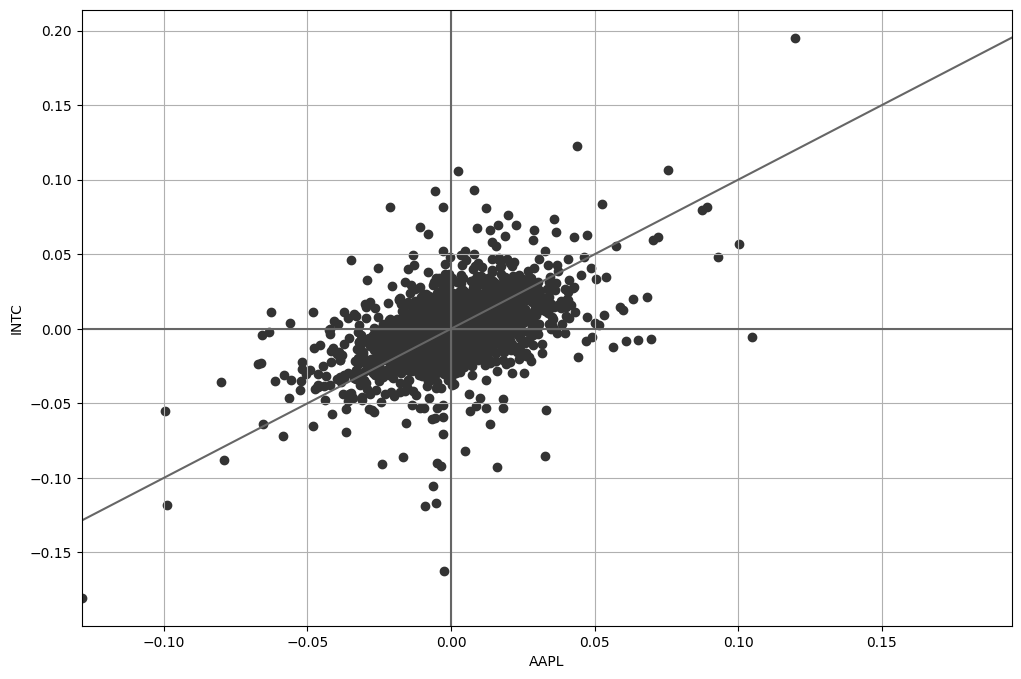

In [100]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore1)

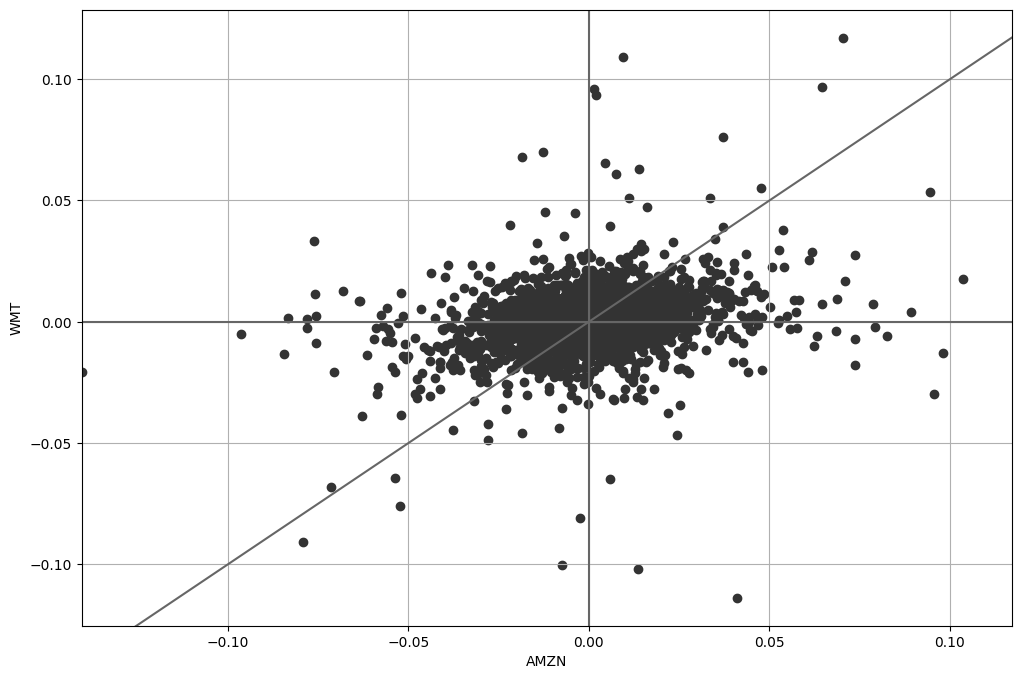

In [101]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore2)

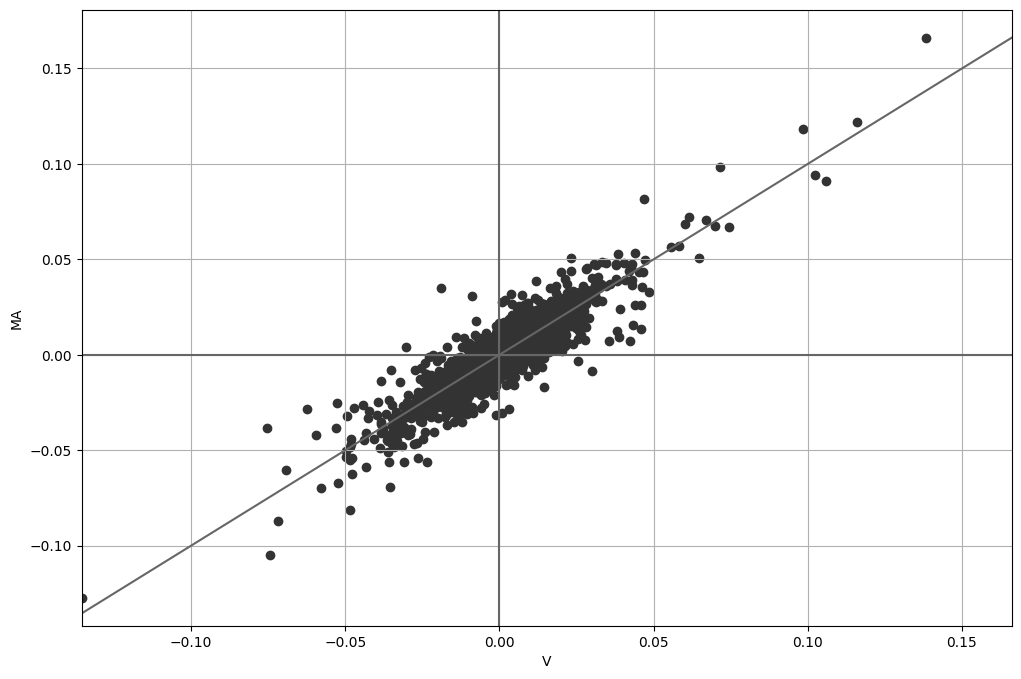

In [102]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore3)

## 3. Analisi di previsione

Utilizziamo il modello lineare ARIMA per effettuare previsioni: per favorire la bontà del modello, concentriamoci sulla serie dei rendimenti. <br>
Per prima cosa verifichiamo che effettivamente la serie dei rendimenti, a differenza di quella dei prezzi, sia stazionaria; per farlo, utilizziamo il test statistico Augmented Dickey Fuller.

In [103]:
risultati_adf = []

for ticker in tickers:
    risultato = adfuller(rendimenti_netti_giornalieri[ticker])
    risultati_adf.append(risultato)
    
    print(f'TITOLO: {ticker}')
    print('ADF: ', risultato[0])
    print('p-value: ', risultato[1])
    for key, value in risultato[4].items():
        print('Critical value (%s): %.3f' % (key, value))
    print('------------')
    

TITOLO: AAPL
ADF:  -15.715722063875713
p-value:  1.342621893094703e-28
Critical value (1%): -3.433
Critical value (5%): -2.863
Critical value (10%): -2.567
------------
TITOLO: INTC
ADF:  -14.235906296247695
p-value:  1.5674562571176927e-26
Critical value (1%): -3.433
Critical value (5%): -2.863
Critical value (10%): -2.567
------------
TITOLO: AMZN
ADF:  -50.8434922869851
p-value:  0.0
Critical value (1%): -3.433
Critical value (5%): -2.863
Critical value (10%): -2.567
------------
TITOLO: WMT
ADF:  -17.415841956678126
p-value:  4.85675221616906e-30
Critical value (1%): -3.433
Critical value (5%): -2.863
Critical value (10%): -2.567
------------
TITOLO: V
ADF:  -13.644307329448587
p-value:  1.6306418421746852e-25
Critical value (1%): -3.433
Critical value (5%): -2.863
Critical value (10%): -2.567
------------
TITOLO: MA
ADF:  -13.601107352391754
p-value:  1.9524109100990746e-25
Critical value (1%): -3.433
Critical value (5%): -2.863
Critical value (10%): -2.567
------------


In [139]:
mesi_training_set = 80
mesi_validation_set = 30
mesi_test_set = 10

training_set = prezzi_chiusura_giornalieri.iloc[:(mesi_training_set * 21)].copy()
validation_set = prezzi_chiusura_giornalieri.iloc[(mesi_training_set * 21):((mesi_training_set + mesi_validation_set) * 21)].copy()
test_set = prezzi_chiusura_giornalieri.iloc[((mesi_training_set + mesi_validation_set) * 21):].copy()

training_set = training_set.asfreq('D')
validation_set = validation_set.asfreq('D')
test_set = test_set.asfreq('D')

training_set.dropna(inplace=True)
validation_set.dropna(inplace=True)
test_set.dropna(inplace=True)

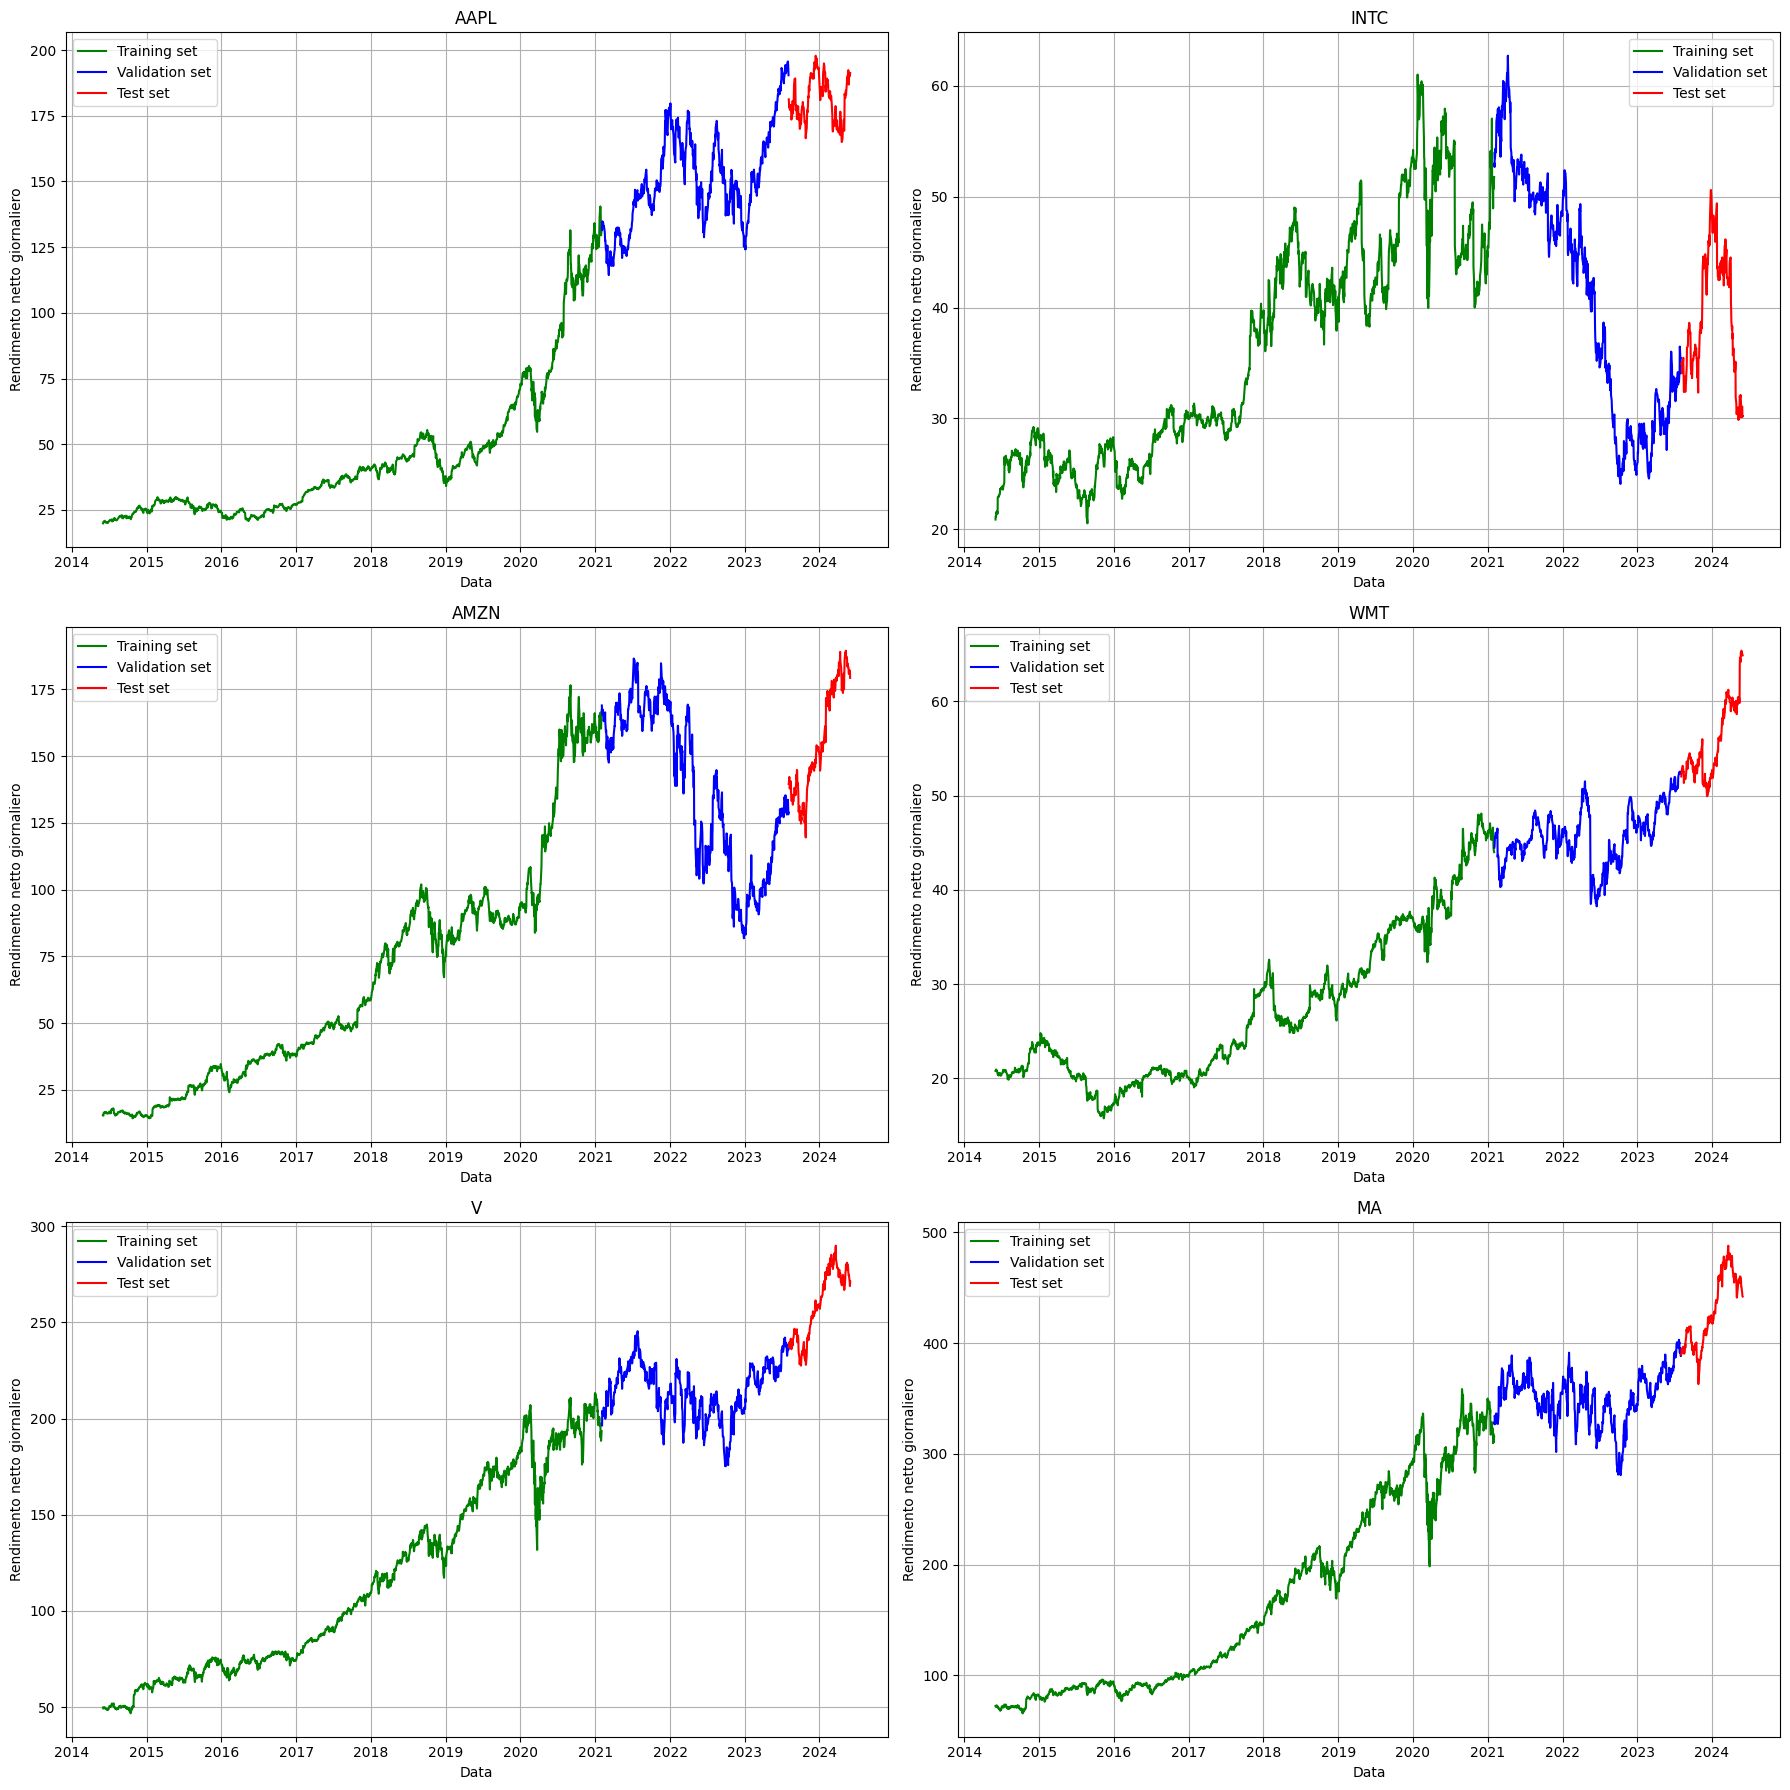

In [140]:
def visualizza_data_set(training_set, validation_set, test_set, label):
    tickers = training_set.columns
    n = len(tickers)
    rows = (n + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(18, 6 * rows))

    if n % 2 != 0:
        axes[-1, -1].axis('off')

    for i, ticker in enumerate(tickers):
        ax = axes[i // 2, i % 2]

        ax.plot(training_set.index, training_set[ticker], label='Training set', color='green')
        ax.plot(validation_set.index, validation_set[ticker], label='Validation set', color='blue')
        ax.plot(test_set.index, test_set[ticker], label='Test set', color='red')
        
        ax.set_title(f'{ticker}')
        ax.set_xlabel('Data')
        ax.set_ylabel(label)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
visualizza_data_set(training_set, validation_set, test_set, label='Rendimento netto giornaliero')

In [141]:
import warnings
warnings.filterwarnings("ignore")

# Definizione delle terne di iperparametri
p_values = [0, 1, 2, 3, 4]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4]

param_combinations = list(itertools.product(p_values, d_values, q_values))

best_score = float('inf')
best_params = None
best_model = None

for (p, d, q) in param_combinations:
    try:
        print(f"Testing ARIMA({p}, {d}, {q})...")
        
        model = ARIMA(training_set['AAPL'], order=(p, d, q))
        model_fit = model.fit()

        # Fai previsioni sul validation set
        forecast = model_fit.forecast(steps=len(validation_set))
        predictions = pd.Series(forecast.values, index=validation_set.index)

        # Calcola l'errore
        mse = mean_squared_error(validation_set['AAPL'], predictions)

        # Se l'errore è il migliore fino ad ora, salva i parametri e il modello
        if mse < best_score:
            best_score = mse
            best_params = (p, d, q)
            best_model = model_fit

    except Exception as e:
        print(f"Exception encountered for ARIMA({p}, {d}, {q}): {str(e)}")
        continue

print(f"Best ARIMA params: {best_params} with MSE: {best_score}")

Testing ARIMA(0, 0, 0)...
Testing ARIMA(0, 0, 1)...
Testing ARIMA(0, 0, 2)...
Testing ARIMA(0, 0, 3)...
Testing ARIMA(0, 0, 4)...
Testing ARIMA(0, 1, 0)...
Testing ARIMA(0, 1, 1)...
Testing ARIMA(0, 1, 2)...
Testing ARIMA(0, 1, 3)...
Testing ARIMA(0, 1, 4)...
Testing ARIMA(0, 2, 0)...
Testing ARIMA(0, 2, 1)...
Testing ARIMA(0, 2, 2)...
Testing ARIMA(0, 2, 3)...
Testing ARIMA(0, 2, 4)...
Testing ARIMA(1, 0, 0)...
Testing ARIMA(1, 0, 1)...
Testing ARIMA(1, 0, 2)...
Testing ARIMA(1, 0, 3)...
Testing ARIMA(1, 0, 4)...
Testing ARIMA(1, 1, 0)...
Testing ARIMA(1, 1, 1)...
Testing ARIMA(1, 1, 2)...
Testing ARIMA(1, 1, 3)...
Testing ARIMA(1, 1, 4)...
Testing ARIMA(1, 2, 0)...
Testing ARIMA(1, 2, 1)...
Testing ARIMA(1, 2, 2)...
Testing ARIMA(1, 2, 3)...
Testing ARIMA(1, 2, 4)...
Testing ARIMA(2, 0, 0)...
Testing ARIMA(2, 0, 1)...
Testing ARIMA(2, 0, 2)...
Testing ARIMA(2, 0, 3)...
Testing ARIMA(2, 0, 4)...
Testing ARIMA(2, 1, 0)...
Testing ARIMA(2, 1, 1)...
Testing ARIMA(2, 1, 2)...
Testing ARIM

In [134]:
pm.auto_arima(pd.concat([training_set['AAPL'], validation_set['AAPL']]), trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9038.316, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9041.653, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9037.534, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9037.084, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9043.942, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9035.976, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9029.129, Time=1.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9036.827, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9038.936, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9037.637, Time=0.89 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9037.051, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9038.971, Time=1.76 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9040.954, Time=0.22 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 6.703 seconds


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [144]:
import math

# Se il modello migliore è stato trovato, utilizza il codice precedente per fare previsioni incrementali sul test set
if best_model is not None:
    
    # Converti i dati in array numpy
    training_data = np.array(training_set['AAPL'])
    testing_data = np.array(test_set['AAPL'])
    
    # Inizializza la lista per memorizzare le previsioni
    model_predictions = []
    
    # Loop sul set di test
    for i in range(len(test_set)):
        print(i)
        # Prevedi il prossimo valore
        output = best_model.forecast(steps=1)
        yhat = output
        model_predictions.append(yhat)
        
        # Ottieni il valore effettivo del test
        actual_test_value = testing_data[i]
        
        # Aggiungi il valore effettivo ai dati di addestramento
        training_data = np.append(training_data, actual_test_value)
        
        # Rifai il fit del modello con i dati di addestramento aggiornati
        best_model = ARIMA(training_data, order=best_params).fit()
    
    # Converti le previsioni del modello in un array numpy per ulteriori analisi se necessario
    model_predictions = np.array(model_predictions)
    
    # Calcola l'errore sul test set
    rmse_test = math.sqrt(mean_squared_error(test_set['AAPL'], model_predictions))
    print(f"RMSE on test set: {rmse_test}")
    
    # Plot delle previsioni e dei dati effettivi
    plt.figure(figsize=(14, 7))
    plt.plot(test_set.index, test_set['AAPL'], label='Actual')
    plt.plot(test_set.index, model_predictions, label='Forecast')
    plt.title('ARIMA Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('AAPL Price')
    plt.legend()
    plt.grid(True)
    plt.show()

0
1
2
3


KeyboardInterrupt: 

## 4. Strategie di trading e backtesting

Procediamo ora con la costruzione di una strategia di trading. <br>
L'idea che si vuole analizzare è quella di combinare l'utilizzo delle medie mobili esponenziali e dell'indice RSI per generare segnali d'acquisto: utilizzando entrambi gli indicatori è possibile tenere conto sia del trend (catturato dalle medie mobili esponenziali) sia del momentum (catturato dall'indice RSI).

In [ ]:
ticker_strategia = 'MA'
indicatori_trading  = prezzi_chiusura_giornalieri[ticker_strategia].copy()
indicatori_trading.rename('Chiusura aggiustata', inplace=True)
indicatori_trading = indicatori_trading.to_frame()

indicatori_trading['EMA20'] = indicatori_trading['Chiusura aggiustata'].ewm(span=20, adjust=False).mean() # calcolo la media mobile esponenziale a 20 giorni
indicatori_trading['EMA50'] = indicatori_trading['Chiusura aggiustata'].ewm(span=50, adjust=False).mean() # calcolo la media mobile esponenziale a 50 giorni

In [ ]:
def calcola_RSI(data, window=14):
    delta = data['Chiusura aggiustata'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

indicatori_trading['RSI'] = calcola_RSI(indicatori_trading) # calcolo l'indice RSI
indicatori_trading.dropna(inplace=True)

indicatori_trading

In [ ]:
# Creazione dei grafici
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Grafico del prezzo di chiusura e delle medie mobili
ax1.plot(indicatori_trading.index, indicatori_trading['Chiusura aggiustata'], label='Chiusura aggiustata')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA20'], label='EMA 20 giorni')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA50'], label='EMA 50 giorni')
ax1.set_title('Prezzo di Chiusura e Medie Mobili')
ax1.set_ylabel('Prezzo')
ax1.legend()
ax1.grid(True)

# Grafico dell'indicatore RSI
ax2.plot(indicatori_trading.index, indicatori_trading['RSI'], label='RSI', color='orange')
ax2.axhline(70, color='black', linestyle='--', linewidth=1)
ax2.axhline(30, color='black', linestyle='--', linewidth=1)
ax2.set_title('Indicatore RSI')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Data')
ax2.legend()
ax2.grid(True)

plt.show()

Dopo aver calcolato gli indicatori di cui abbiamo bisogno, procediamo con l'applicazione della strategia.

Secondo la strategia viene generato un __segnale di acquisto__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dal basso verso l'alto la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al rialzo
- l'indice RSI supera 50, confermando che il trend rialzista è abbastanza intenso

Secondo la strategia viene generato un __segnale di vendita__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dall'alto verso il basso la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al ribasso
- l'indice RSI scende sotto 50, confermando che il trend ribassista è abbastanza intenso

In [ ]:
strategia_trading = indicatori_trading.copy()

condizione_acquisto = ((strategia_trading['EMA20'] > strategia_trading['EMA50']) &
                       (strategia_trading['RSI'] > 50))
                      
condizione_vendita = ((strategia_trading['EMA20'] < strategia_trading['EMA50']) &
                      (strategia_trading['RSI'] < 50))

# Crea la colonna "Posizione" e assegna i valori in base alle condizioni
strategia_trading['Posizione'] = 0  # Inizializza tutte le posizioni a 0

# Imposta le posizioni a 1 quando si verifica la condizione di acquisto
strategia_trading.loc[condizione_acquisto, 'Posizione'] = 1

# Imposta le posizioni a 1 quando si verifica la condizione di vendita
strategia_trading.loc[condizione_vendita, 'Posizione'] = 0

strategia_trading

In [ ]:
# Calcola i rendimenti cumulati delle due strategie # TODO: STRATEGIA DI CALCOLO DI CHATGPT
rendimento_cumulato_strategia = (1 + strategia_trading['Posizione'].diff() * strategia_trading['Chiusura aggiustata'].pct_change()).cumprod()
rendimento_cumulato_buy_and_hold = (1 + strategia_trading['Chiusura aggiustata'].pct_change()).cumprod()

# Crea un grafico
plt.figure(figsize=(18, 10))
plt.plot(rendimento_cumulato_strategia, label='Strategia')
plt.plot(rendimento_cumulato_buy_and_hold, label='Buy and Hold')
plt.title('Confronto dei Rendimenti Cumulati')
plt.xlabel('Data')
plt.ylabel('Rendimento Cumulato')
plt.legend()
plt.grid(True)
plt.show()

## 5. CAPM

Arriviamo quindi alla sezione dedicata al Capital Asset Pricing Model.

Per prima cosa scarichiamo i dati mensili relativi al modello di Fama e French: in questo modo possiamo sfruttare i dati relativi ai tassi risk-free mensili.

In [ ]:
# popoliamo un dataframe con i dati di fama e french mensili
fama_french_mensile = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
fama_french_mensile.rename({'date_ff_factors': 'Date'}, axis=1, inplace=True)
fama_french_mensile.set_index('Date', inplace = True)
fama_french_mensile = fama_french_mensile.loc[inizio: fine] # filtriamo per il periodo di interesse

fama_french_mensile = fama_french_mensile.tail(-2) # rimuovo le prime due righe per allinearlo al dataframe CAPM
fama_french_mensile

Dopodiché scarichiamo i dati relativi al mercato (indice S&P500), ne calcoliamo il rendimento netto mensile e il premio di mercato.

In [ ]:
# scarichiamo da yahoo finance i prezzi di chiusura dell'indice S&P500
sp500 = prendi_dati_titolo('^GSPC', inizio, fine)
sp500.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
sp500.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# ricampioniamo i prezzi su base mensile (prendendo l'ultimo giorno di ciascun mese)
sp500 = sp500.resample("ME").last()

sp500['Rendimento netto mensile'] = sp500['Chiusura aggiustata'].pct_change()
sp500.dropna(inplace=True)

sp500['Premio di mercato'] = sp500['Rendimento netto mensile'] - fama_french_mensile['RF']

sp500

Andiamo poi a comporre un dataframe che raccoglie per ciascun titolo il prezzo di chiusura aggiustato, il rendimento netto mensile ed il premio di rischio.

In [ ]:
dati_mensili_titoli = dataframe_completo.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
dati_mensili_titoli.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# trasformiamo le date in oggetti datetime facilmente manipolabili da pandas
dati_mensili_titoli.index = dati_mensili_titoli.index.set_levels(pd.to_datetime(dati_mensili_titoli.index.levels[1]), level=1)

# per ciascun ticker, ricampioniamo il dataframe su base mensile
dati_mensili_titoli = dati_mensili_titoli.groupby('Ticker').resample('ME', level=1).last()

# calcoliamo il rendimento netto mensile
dati_mensili_titoli['Rendimento netto mensile'] = dati_mensili_titoli.groupby('Ticker')['Chiusura aggiustata'].pct_change()
dati_mensili_titoli = dati_mensili_titoli.dropna()

dati_mensili_titoli['Premio di rischio'] = dati_mensili_titoli['Rendimento netto mensile'] - fama_french_mensile['RF']

dati_mensili_titoli

Definiamo quindi una funzione per effettuare la regressione e stimare il modello.

In [ ]:
def regressione_OLS(ticker, dati_mensili_titoli, dati_mensili_mercato, colore='blue'):
    dati_mensili_titoli = dati_mensili_titoli.dropna()
    dati_mensili_mercato = dati_mensili_mercato.dropna()
    merged_data = pd.merge(dati_mensili_titoli, dati_mensili_mercato, left_index=True, right_index=True)
    data_ticker = merged_data.loc[ticker]

    X = data_ticker['Premio di mercato']
    Y = data_ticker['Rendimento netto mensile_x'] # rendimento netto mensile del titolo
    X1 = sm.add_constant(X)
    model = sm.OLS(Y, X1)
    results = model.fit()

    plt.figure()
    sns.regplot(x='Premio di mercato', y='Rendimento netto mensile_x', data=data_ticker, color=colore)
    plt.grid(axis='both')
    plt.title(f'Regressione per {ticker}')
    plt.xlabel('Premio di mercato')
    plt.ylabel('Rendimento netto mensile del titolo')
    plt.show()

    html_output = '<h4>Esposizione al rischio di mercato per il titolo ' + f'{ticker}</h4>'
    html_output += results.summary().tables[1].as_html()
    html_output += '<br><br>'
    display_html(html_output, raw=True)
    
    return results.params['const'], results.params['Premio di mercato'], results.tvalues['const']

# Definiamo una lista per accumulare i risultati della regressione
parametri_capm = []
valori_t = []

for i, ticker in enumerate(tickers):
    colore = mappa_colori(i % 10)  # L'operazione modulo assicura che non superiamo l'indice massimo della mappa
    intercetta, beta, t_valore = regressione_OLS(ticker, dati_mensili_titoli, sp500, colore)
    parametri_capm.append([ticker, intercetta, beta])
    valori_t.append(t_valore)

Ricapitoliamo infine in un dataframe il coefficiente beta di ciascun titolo.

In [ ]:
# Convertiamo la lista in un DataFrame
coefficienti_capm = pd.DataFrame(parametri_capm, columns=['Ticker', 'Intercetta', 'Beta']).set_index('Ticker')

def significativo(t):
    if abs(t) > 2:
        return 'si'
    else:
        return 'no'

# Aggiungi la colonna 'Significativo' al DataFrame coefficienti_capm
coefficienti_capm['Costante significativa?'] = [significativo(t) for t in valori_t]

coefficienti_capm

Dalla stima del modello CAPM emerge che diversi titoli hanno costante significativa (t>2), a testimonianza dell'esistenza di ulteriori fattori di rischio oltre a quello di mercato.

Utilizziamo i valori beta calcolati in precedenza per calcolare il rendimento atteso annuo di ciascun titolo: per stimare il tasso risk-free utilizziamo l'attuale rendimento dei t-bill a un anno, mentre per stimare il rendimento del mercato utilizziamo una proiezione del rendimento dell'indice S&P500 a un anno (per fare ciò prendiamo il rendimento annuo medio avuto dall'indice dal 1980 ad oggi).

I dati dei t-bill provengono dalla banca dati "Federal Reserve Economic Data" (FRED), link: https://fred.stlouisfed.org/series/DGS1

In [ ]:
file_path = os.path.join('DatiFinanziari', 'DGS1.csv')
tbill_1anno = pd.read_csv(file_path)
tbill_1anno['DATE'] = pd.to_datetime(tbill_1anno['DATE'])
tbill_1anno.set_index('DATE', inplace=True)
tbill_1anno['DGS1'] = pd.to_numeric(tbill_1anno['DGS1'], errors='coerce')
tbill_1anno['DGS1'] = tbill_1anno['DGS1'] / 100

stima_rf = tbill_1anno['DGS1'].loc[:fine].tail(1).iloc[0]

stima_rf # attuale tasso di interesse sui T-Bill a un anno

In [ ]:
tbill_1anno = tbill_1anno.resample('YE').last()

tbill_1anno

In [ ]:
sp500_storico = prendi_dati_titolo('^GSPC', dt.datetime(1980, 1, 2), fine)
sp500_storico.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
sp500_storico = sp500_storico.resample("YE").last()
sp500_storico['Rendimento netto annuo'] = sp500_storico['Adj Close'].pct_change()
sp500_storico.dropna(inplace=True)

sp500_storico

In [ ]:
tbill_1anno = tbill_1anno.loc[sp500_storico.index] # allinea le date di sp500 e t-bill
sp500_storico['Premio di mercato'] = sp500_storico['Rendimento netto annuo'] - tbill_1anno['DGS1']
stima_premio_mercato = sp500_storico['Premio di mercato'].mean()

stima_premio_mercato # media premio di mercato degli ultimi 44 anni

In [ ]:
rendimenti_attesi = stima_rf + coefficienti_capm['Beta'] * stima_premio_mercato
rendimenti_attesi = rendimenti_attesi.rename('Rendimento atteso annuo')

rendimenti_attesi

Ora calcoliamo l'esposizione dei vari titoli ai fattori di Fama e French. <br>
Sfruttiamo i dati scaricati in precedenza.

In [ ]:
def regressione_fama_french(ticker, dati_mensili_titoli, dati_fama_french):
    # Step 1: Pulire i dati
    dati_mensili_titoli = dati_mensili_titoli.dropna()
    dati_fama_french = dati_fama_french.dropna()
    dati_fama_french = dati_fama_french.rename(columns={'Mkt-RF': 'MKT'})
    
    # Step 2: Unire i dati basandosi sulle date
    merged_data = dati_mensili_titoli.join(dati_fama_french)
    merged_data.rename(columns={'Premio di rischio': 'premio_rischio'}, inplace=True)

    # Step 3: Filtrare i dati per il ticker specificato
    dati = merged_data.loc[ticker]
    
    results = smf.ols(formula = 'premio_rischio ~ MKT + SMB + HML', data = dati).fit()
    
    html_output = '<h4>Esposizione ai fattori Fama French per il titolo ' + f'{ticker}</h4>'
    html_output += results.summary().tables[1].as_html()
    html_output += '<br><br>'
    display_html(html_output, raw=True)
    
    # Restituire i coefficienti del modello e i valori t
    return results.params, results.tvalues

parametri_fama_french = []
valori_t = []

for ticker in tickers:
    coefficients, t_values = regressione_fama_french(ticker, dati_mensili_titoli, fama_french_mensile)
    parametri_fama_french.append([ticker] + list(coefficients))
    valori_t.append([ticker] + list(t_values))

In [ ]:
coefficienti_fama_french = pd.DataFrame(parametri_fama_french, columns=['Ticker', 'Intercetta', 'MKT', 'SMB', 'HML'])
coefficienti_fama_french.set_index('Ticker', inplace=True)

valori_t_fama_french = pd.DataFrame(valori_t, columns=['Ticker', 'Intercetta_t', 'MKT_t', 'SMB_t', 'HML_t'])
valori_t_fama_french.set_index('Ticker', inplace=True)

coefficienti_fama_french['Costante significativa?'] = [significativo(t) for t in valori_t_fama_french['Intercetta_t']]
coefficienti_fama_french['MKT significativo?'] = [significativo(t) for t in valori_t_fama_french['MKT_t']]
coefficienti_fama_french['SMB significativo?'] = [significativo(t) for t in valori_t_fama_french['SMB_t']]
coefficienti_fama_french['HML significativo?'] = [significativo(t) for t in valori_t_fama_french['HML_t']]

coefficienti_fama_french

## 6. Ottimizzazione di portafoglio

In [ ]:
num_mesi = 108
num_portafogli = 100000

Definiamo tutte le funzioni che utilizzeremo per effettuare l'ottimizzazione di portafoglio.

In [ ]:
# Funzioni per il calcolo del portafoglio ottimale
def genera_pesi(num_portafogli, num_titoli, seed=42):
    np.random.seed(seed)
    pesi = np.random.random(size=(num_portafogli, num_titoli))
    pesi = pesi / np.sum(pesi, axis=1)[:, np.newaxis]
    return pesi

def calcola_rendimenti_volatilita_portafogli(pesi, rendimenti, matrice_covarianza):
    rendimenti_portafogli = np.dot(pesi, rendimenti)
    volatilita_portafogli = np.array([np.sqrt(np.dot(w.T, np.dot(matrice_covarianza, w))) for w in pesi])
    return rendimenti_portafogli, volatilita_portafogli

def calcola_sharpe_ratio(rendimenti_portafogli, volatilita_portafogli, stima_rf):
    sharpe_ratio_portafogli = (rendimenti_portafogli - stima_rf) / volatilita_portafogli
    return sharpe_ratio_portafogli

def crea_dataframe_risultati(rendimenti_portafogli, volatilita_portafogli, sharpe_ratio_portafogli):
    risultati_portafogli = pd.DataFrame({
        'Rendimenti': rendimenti_portafogli,
        'Volatilità': volatilita_portafogli,
        'Sharpe Ratio': sharpe_ratio_portafogli
    })
    return risultati_portafogli

def trova_portafoglio_max_sharpe(risultati_portafogli):
    max_sr_index = np.argmax(risultati_portafogli['Sharpe Ratio'])
    return risultati_portafogli.loc[max_sr_index]

def visualizza_risultati(risultati_portafogli, volatilita_frontiera_efficiente, rendimenti_frontiera_efficiente, tickers, matrice_covarianza, rendimenti_medi_annualizzati):
    fig, ax = plt.subplots(figsize=(18, 10))
    risultati_portafogli.plot(kind='scatter', x='Volatilità', y='Rendimenti', c='Sharpe Ratio', cmap='RdYlGn', edgecolors='black', ax=ax)
    ax.set(xlabel='Volatilità', ylabel='Rendimento atteso', title='Frontiera efficiente')
    ax.plot(volatilita_frontiera_efficiente, rendimenti_frontiera_efficiente, 'b--')
    
    simboli = ['o', 'X', 'd', '*', '^', 'v']
    for i, ticker in enumerate(tickers):
        ax.scatter(x=np.sqrt(matrice_covarianza.values[i, i]), y=rendimenti_medi_annualizzati.iloc[i], marker=simboli[i % len(simboli)], s=150, color='black', label=ticker)
    ax.legend()
    
    plt.tight_layout()
    plt.grid()
    plt.show()

def prendi_ritorno_portafoglio(w, avg_rtns):
    return np.sum(avg_rtns * w)

def prendi_volatilita_portafoglio(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def prendi_frontiera_efficiente(avg_rtns, cov_mat, rtns_range):
    portafogli_efficienti = []
    num_titoli = len(avg_rtns)
    argomenti = (avg_rtns, cov_mat)
    limiti = tuple((0, 1) for asset in range(num_titoli))
    valore_iniziale = num_titoli * [1. / num_titoli, ]
    
    for ret in rtns_range:
        vincoli = [{'type': 'eq', 'fun': lambda x: prendi_ritorno_portafoglio(x, avg_rtns) - ret},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        portafoglio_efficiente = sco.minimize(prendi_volatilita_portafoglio, valore_iniziale, args=argomenti, method='SLSQP', constraints=vincoli, bounds=limiti)
        portafogli_efficienti.append(portafoglio_efficiente)
    
    return portafogli_efficienti

def trova_portafoglio_max_sharpe_analitico(rendimenti_frontiera, volatilita_frontiera, rf, portafogli_efficienti):
    sharpe_ratios = (rendimenti_frontiera - rf) / volatilita_frontiera
    max_sharpe_idx = np.argmax(sharpe_ratios)
    max_sharpe_port = portafogli_efficienti[max_sharpe_idx]
    max_sharpe_weights = max_sharpe_port['x']
    return {
        'Return': rendimenti_frontiera[max_sharpe_idx],
        'Volatility': volatilita_frontiera[max_sharpe_idx],
        'Sharpe Ratio': sharpe_ratios[max_sharpe_idx],
        'Weights': max_sharpe_weights
    }


# Calcoli preliminari
pesi = genera_pesi(num_portafogli, len(tickers))

pesi

Calcoliamo i rendimenti medi annualizzati e la matrice di covarianza che utilizzeremo per calcolare rendimenti e volatilità di ciascun portafoglio (generato casualmente con il metodo monte carlo o ricavato con l'ottimizzazione di scipy).

In [ ]:
rendimenti_netti_mensili = prezzi_chiusura_giornalieri.resample('ME').last().pct_change()
rendimenti_netti_mensili.dropna(inplace=True)

rendimenti_medi_annualizzati = rendimenti_netti_mensili.iloc[:num_mesi].mean() * 12
rendimenti_medi_annualizzati.name = 'Rendimento netto medio annualizzato'
matrice_covarianza = rendimenti_netti_mensili.iloc[:num_mesi].cov() * 12

In [ ]:
rendimenti_medi_annualizzati

In [ ]:
matrice_covarianza

In [ ]:
# Metodo di simulazione con rendimenti storici
rendimenti_sim, volatilita_sim = calcola_rendimenti_volatilita_portafogli(pesi, rendimenti_medi_annualizzati, matrice_covarianza)
sharpe_ratio_sim = calcola_sharpe_ratio(rendimenti_sim, volatilita_sim, stima_rf)
risultati_sim = crea_dataframe_risultati(rendimenti_sim, volatilita_sim, sharpe_ratio_sim)
portafoglio_max_sr_sim = trova_portafoglio_max_sharpe(risultati_sim)

In [ ]:
# Calcolo della frontiera efficiente usando il metodo analitico
range_ritorni_an = np.linspace(risultati_sim['Rendimenti'].min(), risultati_sim['Rendimenti'].max(), 100)
portafogli_efficienti_an = prendi_frontiera_efficiente(rendimenti_medi_annualizzati, matrice_covarianza, range_ritorni_an)
volatilita_frontiera_efficiente_an = [port['fun'] for port in portafogli_efficienti_an]
rendimenti_frontiera_efficiente_an = range_ritorni_an
portafoglio_max_sr_an = trova_portafoglio_max_sharpe_analitico(rendimenti_frontiera_efficiente_an, volatilita_frontiera_efficiente_an, stima_rf, portafogli_efficienti_an)

In [ ]:
# Visualizzazione dei risultati
visualizza_risultati(risultati_sim, volatilita_frontiera_efficiente_an, rendimenti_frontiera_efficiente_an, tickers, matrice_covarianza, rendimenti_medi_annualizzati)

In [ ]:
pesi_sim = {
    'Peso': [f"{100*y:.2f}%" for y in pesi[np.argmax(sharpe_ratio_sim)]]
}
dataframe_pesi_sim = pd.DataFrame(pesi_sim, index=tickers)

beta_portf_sim = np.dot(coefficienti_capm['Beta'], pesi[np.argmax(sharpe_ratio_sim)])

# Performance del portafoglio ottimale (simulazione)
performance_sim = {
    'Valore': [f"{portafoglio_max_sr_sim['Rendimenti']*100:.2f}%", 
               f"{portafoglio_max_sr_sim['Volatilità']*100:.2f}%", 
               f"{portafoglio_max_sr_sim['Sharpe Ratio']:.2f}", 
               f"{beta_portf_sim:.2f}"]
}
dataframe_performance_sim = pd.DataFrame(performance_sim, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio', 'Beta'])

# Visualizzazione performance portafoglio ottimale
display_html('<h4>Portafoglio ottimale in termini di media-varianza con rendimenti passati (simulazione)</h4><br>', raw=True)
display(dataframe_performance_sim)
display(dataframe_pesi_sim)

In [ ]:
pesi_an = {
    'Peso': [f"{100*y:.2f}%" for y in portafoglio_max_sr_an['Weights']]
}
dataframe_pesi_an = pd.DataFrame(pesi_an, index=tickers)

beta_portf_an = np.dot(coefficienti_capm['Beta'], portafoglio_max_sr_an['Weights'])

# Performance del portafoglio ottimale (analitico)
performance_an = {
    'Valore': [f"{portafoglio_max_sr_an['Return']*100:.2f}%", 
               f"{portafoglio_max_sr_an['Volatility']*100:.2f}%", 
               f"{portafoglio_max_sr_an['Sharpe Ratio']:.2f}",
               f"{beta_portf_an:.2f}"]
}
dataframe_performance_an = pd.DataFrame(performance_an, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio', 'Beta'])



display_html('<h4>Portafoglio ottimale in termini di media-varianza con rendimenti passati (metodo analitico)</h4><br>', raw=True)
display(dataframe_performance_an)
display(dataframe_pesi_an)

In [ ]:
# Metodo di simulazione con rendimenti attesi
rendimenti_sim, volatilita_sim = calcola_rendimenti_volatilita_portafogli(pesi, rendimenti_attesi, matrice_covarianza)
sharpe_ratio_sim = calcola_sharpe_ratio(rendimenti_sim, volatilita_sim, stima_rf)
risultati_sim = crea_dataframe_risultati(rendimenti_sim, volatilita_sim, sharpe_ratio_sim)
portafoglio_max_sr_sim = trova_portafoglio_max_sharpe(risultati_sim)

In [ ]:
# Calcolo della frontiera efficiente usando il metodo analitico
range_ritorni_an = np.linspace(risultati_sim['Rendimenti'].min(), risultati_sim['Rendimenti'].max(), 100)
portafogli_efficienti_an = prendi_frontiera_efficiente(rendimenti_attesi, matrice_covarianza, range_ritorni_an)
volatilita_frontiera_efficiente_an = [port['fun'] for port in portafogli_efficienti_an]
rendimenti_frontiera_efficiente_an = range_ritorni_an
portafoglio_max_sr_an = trova_portafoglio_max_sharpe_analitico(rendimenti_frontiera_efficiente_an, volatilita_frontiera_efficiente_an, stima_rf, portafogli_efficienti_an)

In [ ]:
# Visualizzazione dei risultati
visualizza_risultati(risultati_sim, volatilita_frontiera_efficiente_an, rendimenti_frontiera_efficiente_an, tickers, matrice_covarianza, rendimenti_attesi)

In [ ]:
pesi_sim = {
    'Peso': [f"{100*y:.2f}%" for y in pesi[np.argmax(sharpe_ratio_sim)]]
}
dataframe_pesi_sim = pd.DataFrame(pesi_sim, index=tickers)

beta_portf_sim = np.dot(coefficienti_capm['Beta'], pesi[np.argmax(sharpe_ratio_sim)])

# Performance del portafoglio ottimale (simulazione)
performance_sim = {
    'Valore': [f"{portafoglio_max_sr_sim['Rendimenti']*100:.2f}%", 
               f"{portafoglio_max_sr_sim['Volatilità']*100:.2f}%", 
               f"{portafoglio_max_sr_sim['Sharpe Ratio']:.2f}", 
               f"{beta_portf_sim:.2f}"]
}
dataframe_performance_sim = pd.DataFrame(performance_sim, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio', 'Beta'])

# Visualizzazione performance portafoglio ottimale
display_html('<h4>Portafoglio ottimale in termini di media-varianza con rendimenti attesi (simulazione)</h4><br>', raw=True)
display(dataframe_performance_sim)
display(dataframe_pesi_sim)

In [ ]:
pesi_an = {
    'Peso': [f"{100*y:.2f}%" for y in portafoglio_max_sr_an['Weights']]
}
dataframe_pesi_an = pd.DataFrame(pesi_an, index=tickers)

beta_portf_an = np.dot(coefficienti_capm['Beta'], portafoglio_max_sr_an['Weights'])

# Performance del portafoglio ottimale (analitico)
performance_an = {
    'Valore': [f"{portafoglio_max_sr_an['Return']*100:.2f}%", 
               f"{portafoglio_max_sr_an['Volatility']*100:.2f}%", 
               f"{portafoglio_max_sr_an['Sharpe Ratio']:.2f}",
               f"{beta_portf_an:.2f}"]
}
dataframe_performance_an = pd.DataFrame(performance_an, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio', 'Beta'])



display_html('<h4>Portafoglio ottimale in termini di media-varianza con rendimenti attesi (metodo analitico)</h4><br>', raw=True)
display(dataframe_performance_an)
display(dataframe_pesi_an)

In [ ]:
peso_titolo = 1.0 / len(tickers)
pesi_uguali = np.full((1, len(tickers)), peso_titolo)
pesi_uguali = pesi_uguali / np.sum(pesi_uguali, axis=1)[:, np.newaxis]

In [ ]:
rendimento_portf_eff, volatilita_portf_eff = calcola_rendimenti_volatilita_portafogli(pesi_uguali, rendimenti_medi_annualizzati, matrice_covarianza)
sharpe_ratio_portf_eff = calcola_sharpe_ratio(rendimento_portf_eff, volatilita_portf_eff, stima_rf)
risultati_portf_eff = crea_dataframe_risultati(rendimento_portf_eff, volatilita_portf_eff, sharpe_ratio_portf_eff)

In [ ]:
pesi_portf_eff = {
    'Peso': [f"{100*y:.2f}%" for y in pesi[np.argmax(sharpe_ratio_portf_eff)]]
}
dataframe_pesi_portf_eff = pd.DataFrame(pesi_portf_eff, index=tickers)

# Performance del portafoglio ottimale (simulazione)
performance_portf_eff = {
    'Valore': [f"{risultati_portf_eff['Rendimenti'].values[0]*100:.2f}%", 
               f"{risultati_portf_eff['Volatilità'].values[0]*100:.2f}%", 
               f"{risultati_portf_eff['Sharpe Ratio'].values[0]:.2f}"]
}
dataframe_performance_portf_eff = pd.DataFrame(performance_portf_eff, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio'])

# Visualizzazione performance portafoglio ottimale
display_html('<h4>Portafoglio effettivo con rendimenti passati </h4><br>', raw=True)
display(dataframe_performance_portf_eff)
display(dataframe_pesi_portf_eff)

In [ ]:
rendimento_portf_eff, volatilita_portf_eff = calcola_rendimenti_volatilita_portafogli(pesi, rendimenti_attesi, matrice_covarianza)
sharpe_ratio_portf_eff = calcola_sharpe_ratio(rendimento_portf_eff, volatilita_portf_eff, stima_rf)
risultati_portf_eff = crea_dataframe_risultati(rendimento_portf_eff, volatilita_portf_eff, sharpe_ratio_portf_eff)

In [ ]:
pesi_portf_eff = {
    'Peso': [f"{100*y:.2f}%" for y in pesi[np.argmax(sharpe_ratio_portf_eff)]]
}
dataframe_pesi_portf_eff = pd.DataFrame(pesi_portf_eff, index=tickers)

# Performance del portafoglio ottimale (simulazione)
performance_portf_eff = {
    'Valore': [f"{risultati_portf_eff['Rendimenti'].values[0]*100:.2f}%", 
               f"{risultati_portf_eff['Volatilità'].values[0]*100:.2f}%", 
               f"{risultati_portf_eff['Sharpe Ratio'].values[0]:.2f}"]
}
dataframe_performance_portf_eff = pd.DataFrame(performance_portf_eff, index=['Rendimenti', 'Volatilità', 'Sharpe Ratio'])

# Visualizzazione performance portafoglio ottimale
display_html('<h4>Portafoglio effettivo con rendimenti attesi </h4><br>', raw=True)
display(dataframe_performance_portf_eff)
display(dataframe_pesi_portf_eff)